In [36]:
import silence_tensorflow.auto
import pandas as pd
import numpy as np
from epigenomic_dataset import load_epigenomes, active_promoters_vs_inactive_promoters, active_enhancers_vs_inactive_enhancers
from tqdm.auto import tqdm
from cache_decorator import Cache
import seaborn as sns
import matplotlib.pyplot as plt
from barplots import barplots

In [ ]:
!pip install scikit-learn barplots plot_keras_history epigenomic_dataset ucsc_genomes_downloader keras_bed_sequence seaborn minepy boruta prince cmake multicoretsne silence_tensorflow extra_keras_metrics

# Loading data

In [2]:
cell_line = "HepG2"

In [3]:
X_enh, y_enh = active_enhancers_vs_inactive_enhancers(
    cell_line = cell_line,
    dataset = "fantom",
    window_size = 256,
    root = "datasets" # Path where to download data
)
X_pro, y_pro = active_promoters_vs_inactive_promoters(
    cell_line = cell_line,
    dataset = "fantom",
    window_size = 256,
    root = "datasets" # Path where to download data
)

In [4]:
epigenomes = {
    "promoters": X_pro,
    "enhancers": X_enh
}

labels = {
    "promoters": y_pro,
    "enhancers": y_enh
}

### Binarize labels

In [5]:
tpm_activation_threshold_enh = 0
tpm_activation_threshold_pro = 1


bin_arr = { 
    "promoters" : np.ndarray(len(labels["promoters"]), dtype='bool'),
    "enhancers" : np.ndarray(len(labels["enhancers"]), dtype='bool')
}


for region, th in ("promoters", tpm_activation_threshold_pro), ("enhancers", tpm_activation_threshold_enh): 
    i=0
    for labl in labels[region].values:
        if labl > th:
            bin_arr[region][i] = True
        else:
            bin_arr[region][i] = False
        i+=1

binary_labels = {
    "promoters" : pd.DataFrame(
                        bin_arr["promoters"],
                        index = labels["promoters"].index,
                        columns=[cell_line]
                    ),
    "enhancers": pd.DataFrame(
                    bin_arr["enhancers"],
                    index = labels["enhancers"].index,
                    columns=[cell_line]
                )
}

In [6]:
epigenomes_test = {
    "promoters": epigenomes["promoters"].head(100),
    "enhancers": epigenomes["enhancers"].head(100)
}
binary_labels_test = {
    "promoters" : binary_labels["promoters"].head(100),
    "enhancers": binary_labels["enhancers"].head(100)
}
labels_test = {
    "promoters" : labels["promoters"].head(100),
    "enhancers": labels["enhancers"].head(100)
}

# Pre processing

## Imputation and scaling

In [37]:
print(epigenomes["promoters"].isna().sum().sum())
print(epigenomes["enhancers"].isna().sum().sum())
print(epigenomes["promoters"].mean().mean())

359
19
2.0361554342216337


In [38]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

def impute_and_scale(df, imputer, scaler)->pd.DataFrame:
    """Impute null values and scale them using the given imputer and scaler"""
    return pd.DataFrame(
        scaler.fit_transform(
            imputer.fit_transform(df.values)
        ),
        columns=df.columns,
        index=df.index
    )

imputer = KNNImputer(n_neighbors=5)
scaler = RobustScaler()

epigenomes = {
    region: impute_and_scale(x, imputer, scaler)
    for region, x in epigenomes.items()
}

In [39]:
print(epigenomes["promoters"].isna().sum().sum())
print(epigenomes["enhancers"].isna().sum().sum())
print(epigenomes["promoters"].mean().mean())

0
0
0.2964123953389853


## Correlation analysis

### Correlation with output analysis

In [40]:
from scipy.stats import pearsonr, spearmanr, entropy
from minepy import MINE

def get_uncorrelated_data(
    epigenomes, 
    labels,
    p_value_threshold, 
    correlation_threshold,
    
):
    """Run pearson, Spearman on epigenomes data in order to detected uncorrelated data, on the candidate uncorrelated
    data, run the Maximal Information Coefficient test to confirm the supposition."""
    uncorrelated = {
        region: set()
        for region in epigenomes
    }
    for region, x in epigenomes.items():
        for column in tqdm(
            x.columns, 
            desc=f"Running Pearson and Spearman test for {region}", 
            dynamic_ncols=True, 
            leave=False
        ):
            # Person correlation...
            correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
            
            if p_value > p_value_threshold:
                print(region, column, correlation, "pvalue", p_value)
                uncorrelated[region].add(column)
            
            #Spearman correlation...
            
            correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
            
            if p_value > p_value_threshold:
                print(region, column, correlation)
                uncorrelated[region].add(column)
    
    #Maximal Information Coefficient...
    
    remove_from_uncorrelated = []
    
    for region, x in epigenomes.items():
        for column in tqdm(uncorrelated[region], desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=False):
            mine = MINE()
            mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
            score = mine.mic()
            if score < correlation_threshold:
                print(region, column, score)
            else:
                remove_from_uncorrelated.append((region, column))
    
    for region, col in remove_from_uncorrelated:
        uncorrelated[region].remove(col)
                
    return uncorrelated

In [41]:
p_value_threshold = 0.01
correlation_threshold = 0.05
uncorrelated = get_uncorrelated_data(epigenomes, labels, p_value_threshold, correlation_threshold)

for region, x in epigenomes.items():
    epigenomes[region] = x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

Running Pearson and Spearman test for promoters:   0%|  | 0/562 [00:00<?, ?it/s]

promoters ZNF432 0.004996003115910273 pvalue 0.11435333176878695
promoters ZNF10 0.0003732184660054362 pvalue 0.90610701740083
promoters ZNF382 0.00677174228647673 pvalue 0.03234376402158338
promoters SRSF9 0.0028074719913777193 pvalue 0.3749374062558265
promoters MAFG -0.007220102470950933 pvalue 0.022498838479219914
promoters NBN 0.007103877081029074 pvalue 0.024761304413562297
promoters ZNF296 0.006674207082427173 pvalue 0.034917786901175404
promoters RFX1 0.005537298397675314 pvalue 0.08011886038295174
promoters MATR3 -0.0007661977230089534 pvalue 0.8086671968189054
promoters ZNF282 0.0022591562556434543 pvalue 0.47524281655975104
promoters ATF4 0.006524663048402756 pvalue 0.039203190805863174
promoters H3K4me2 0.0016603007815855658 pvalue 0.5997816660700899
promoters ATM 0.00492925333934778 pvalue 0.11927379047391268
promoters SETDB1 0.0032804293483191353 pvalue 0.2998592619293387
promoters SMARCE1 -0.007164686313700426 pvalue 0.0235541335705077
promoters ZNF737 -0.001195268333914

Running Pearson and Spearman test for enhancers:   0%|  | 0/562 [00:00<?, ?it/s]

enhancers ZNF382 -0.0033704881837308487 pvalue 0.39650321073860434
enhancers SNRNP70 -0.003977898923440719 pvalue 0.31697924877659484
enhancers SNRNP70 0.008821572864552468
enhancers NBN 0.00033358223364436397 pvalue 0.9331232237892729
enhancers ARNT 0.00348104634801242 pvalue 0.3811957926874554
enhancers ZNF282 -0.008727334154426999 pvalue 0.028128385880130422
enhancers ATM 0.007265027428390267 pvalue 0.06760729669126156


Running MINE test for promoters:   0%|                   | 0/16 [00:00<?, ?it/s]

promoters ZNF432 0.01672575121200733
promoters SMARCE1 0.013442864285832065
promoters MAFG 0.01442156054104371
promoters MATR3 0.021544313461805176
promoters ZNF296 0.01613011229352336
promoters ZNF737 0.015255144348224928
promoters ZNF282 0.01568284810916884
promoters ATM 0.01585105916404612
promoters RFX1 0.02439030607147963
promoters ZNF10 0.01647215846890137
promoters ZNF382 0.013234271541177659
promoters NBN 0.012445405188833823
promoters ATF4 0.01705474801146144
promoters SRSF9 0.03574900016807747
promoters SETDB1 0.012195301943972144


Running MINE test for enhancers:   0%|                    | 0/6 [00:00<?, ?it/s]

enhancers ARNT 0.004911595601605798
enhancers SNRNP70 0.007063210149030621
enhancers ZNF282 0.004270982693335985
enhancers ATM 0.00555903206080811
enhancers ZNF382 0.005574408218009011
enhancers NBN 0.004497730405714497


### Correlation between features

In [12]:
def get_extremely_correlated_and_scores(
    epigenomes,
    labels,
    p_value_threshold,
    correlation_threshold
):

    extremely_correlated = {
        region: set()
        for region in epigenomes
    }

    scores = {
        region: []
        for region in epigenomes
    }

    for region, x in epigenomes.items():
        for i, column in tqdm(
            enumerate(x.columns),
            total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
            for feature in x.columns[i+1:]:
                correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
                correlation = np.abs(correlation)
                if p_value < p_value_threshold and correlation > correlation_threshold:
                    print(region, column, feature, correlation)
                    if entropy(x[column]) > entropy(x[feature]):
                        extremely_correlated[region].add(feature)
                    else:
                        extremely_correlated[region].add(column)
                else:
                    scores[region].append((correlation, column, feature))
    
    scores = {
        region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
        for region, score in scores.items()
    }
    
    return extremely_correlated, scores

In [13]:
p_value_threshold = 0.01
correlation_threshold = 0.95

extreme_corr, scores = get_extremely_correlated_and_scores(epigenomes, binary_labels, p_value_threshold, correlation_threshold)

print("Number of extremely correlated features: " + str(len(extreme_corr["enhancers"]) + len(extreme_corr["promoters"])))

Running Pearson test for promoters:   0%|                                                                     …

promoters ZNF580 ERF 0.9578129785007432
promoters ZBTB25 ZNF639 0.9553346670101621
promoters KLF16 ZGPAT 0.9520685292986509
promoters KLF16 ERF 0.9523010352412475
promoters ZNF274 ZNF883 0.9565026558276937
promoters SAP130 ARID4B 0.9727426287573447
promoters ZNF407 ZNF883 0.9515272947230292
promoters NFYB NFYC 0.9577113198292296


Running Pearson test for enhancers:   0%|                                                                     …

enhancers SOX13 SOX5 0.9567474565697273
enhancers SAP130 ARID4B 0.9534193841276777
Number of extremely correlated features: 9


There are just 2 extremely correlated pairs, so I can ignore them, now plot the correlation between the features

In [ ]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

Most correlated features from promoters epigenomes
Least correlated features from promoters epigenomes
Most correlated features from enhancers epigenomes
Least correlated features from enhancers epigenomes


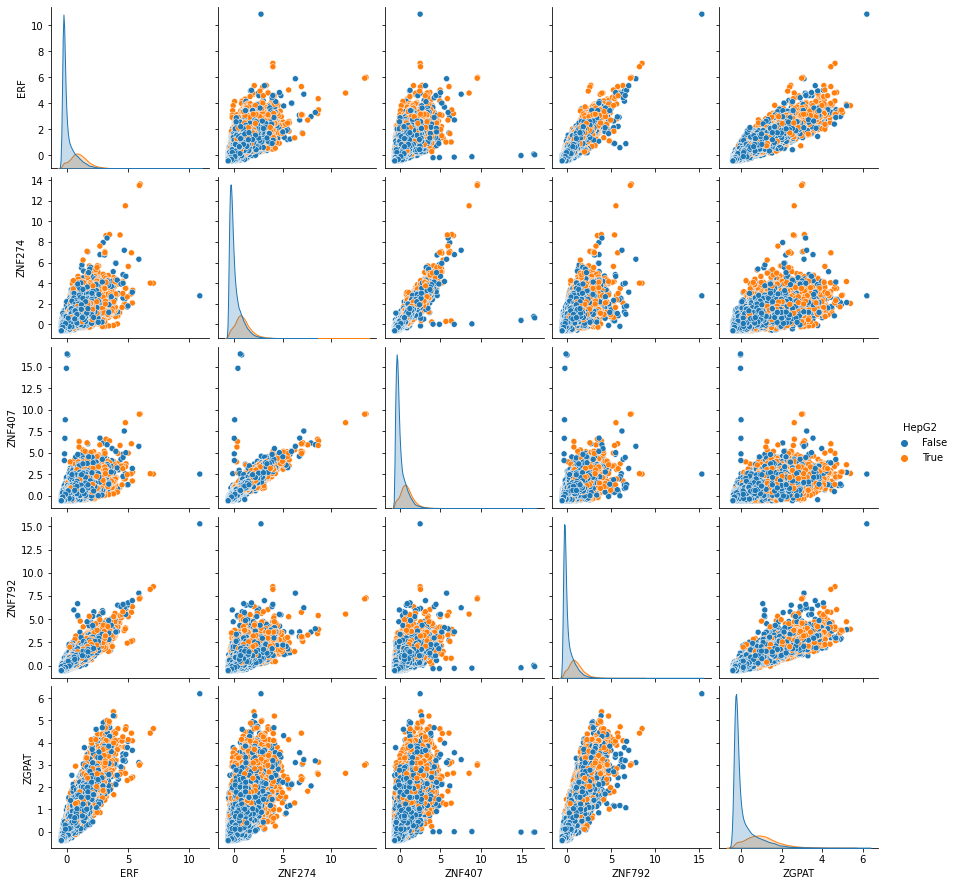

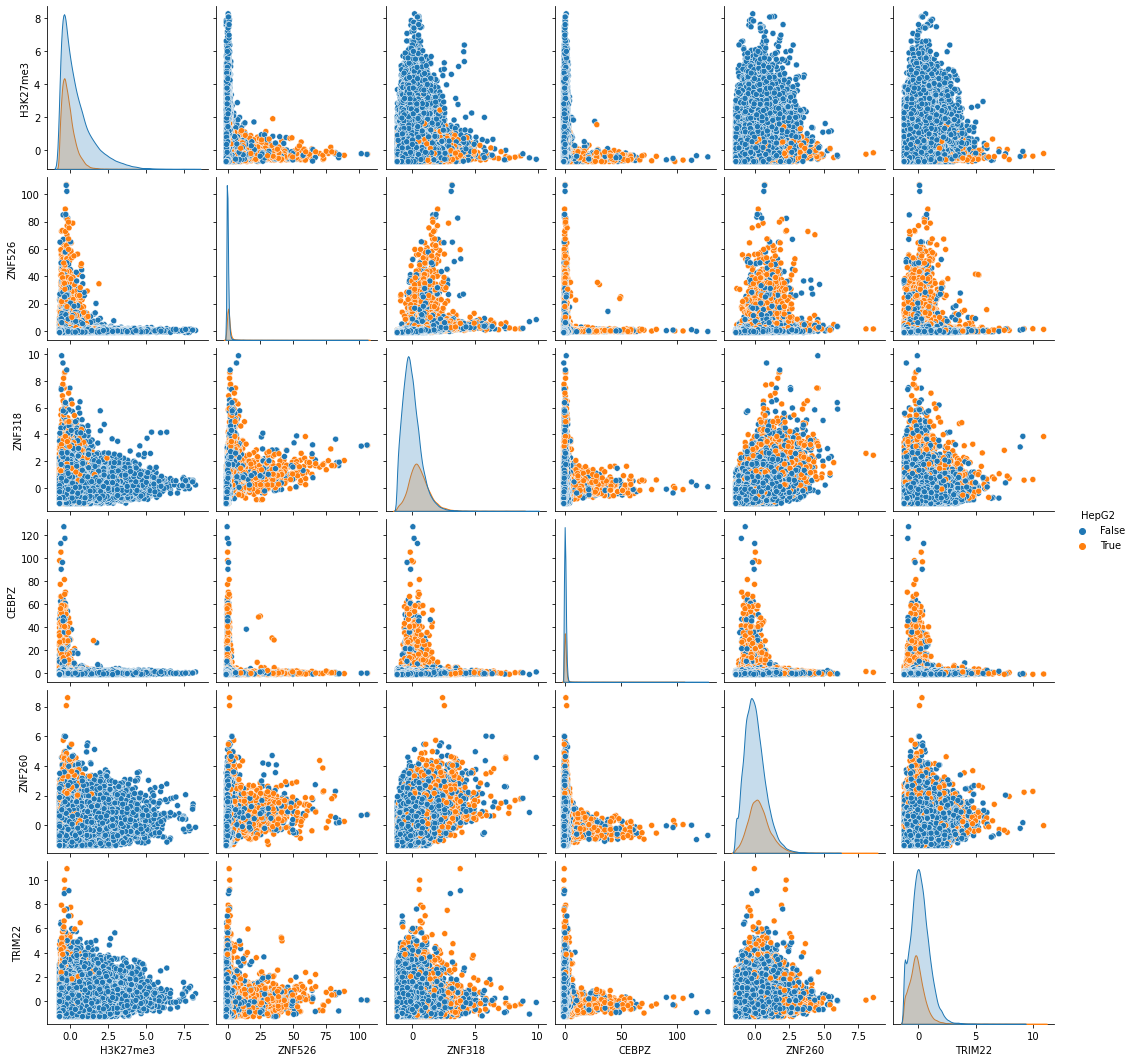

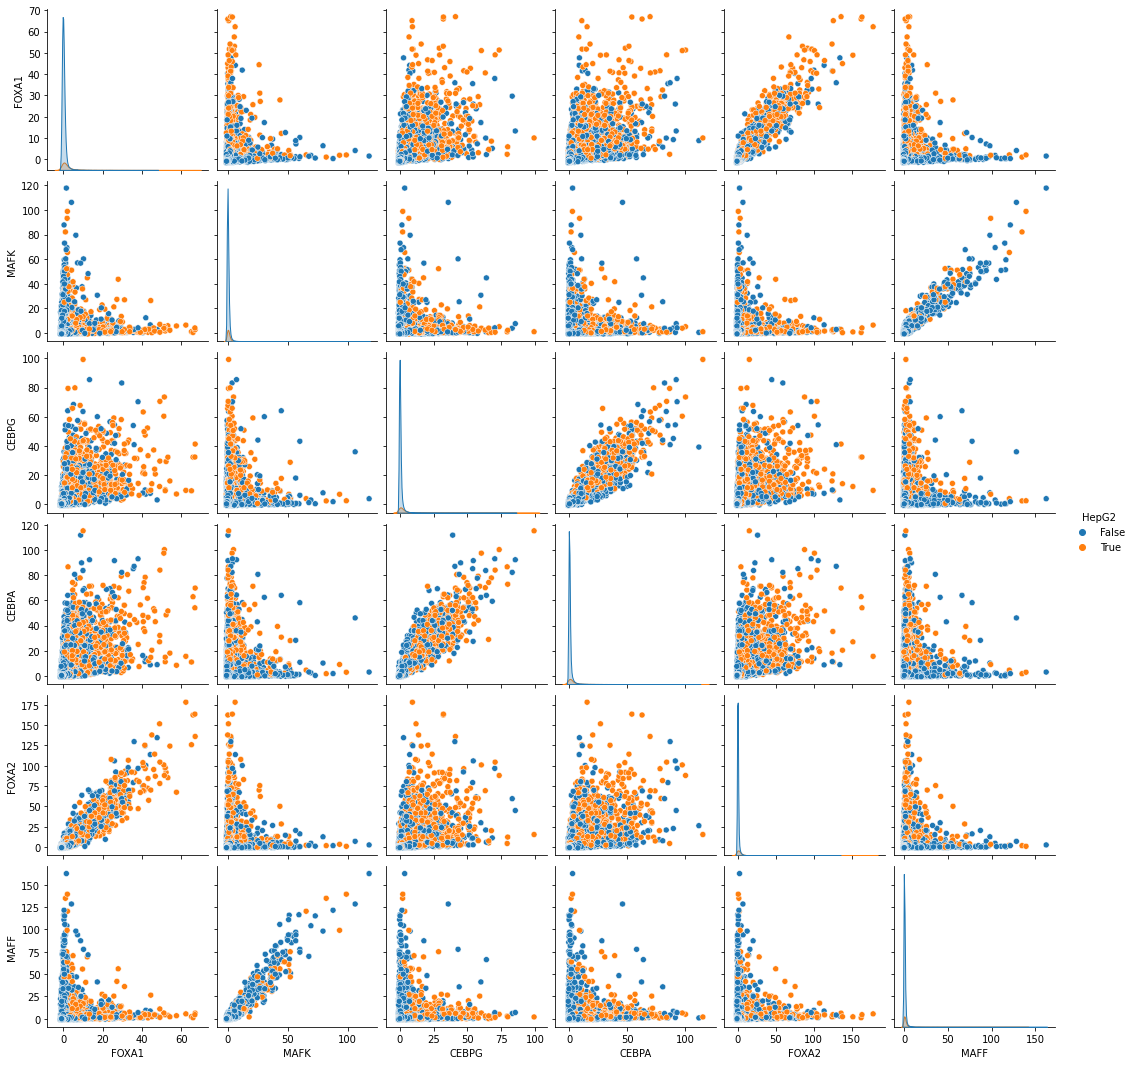

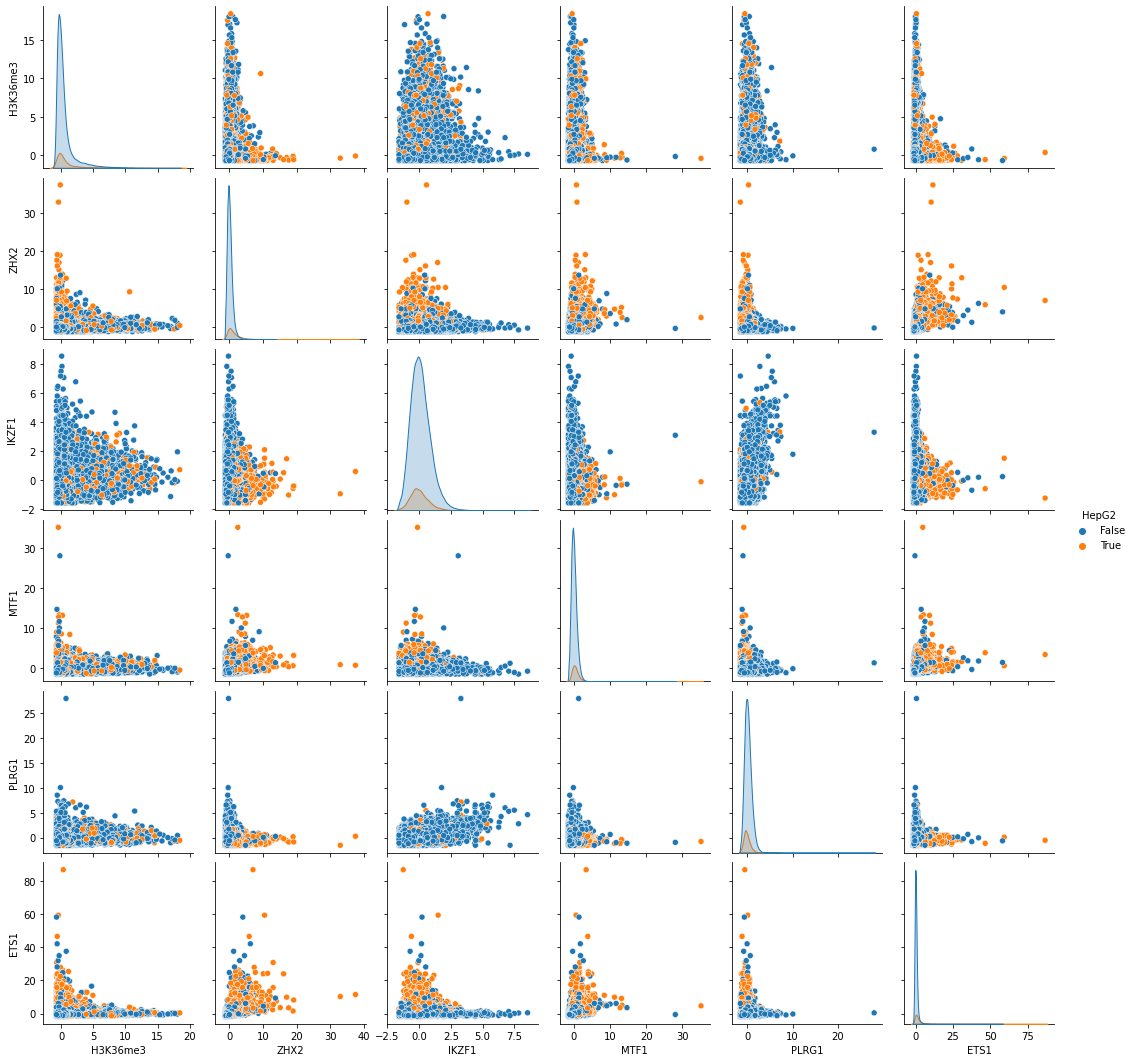

In [ ]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        binary_labels[region],
    ], axis=1), hue=binary_labels[region].columns[0])
    
    _, firsts, seconds = list(zip(*scores[region][-3:]))
    columns = list(set(firsts+seconds))
    print(f"Least correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        binary_labels[region],
    ], axis=1), hue=binary_labels[region].columns[0])
    
    

## Distribution of the features

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

Top 5 different features from promoters.


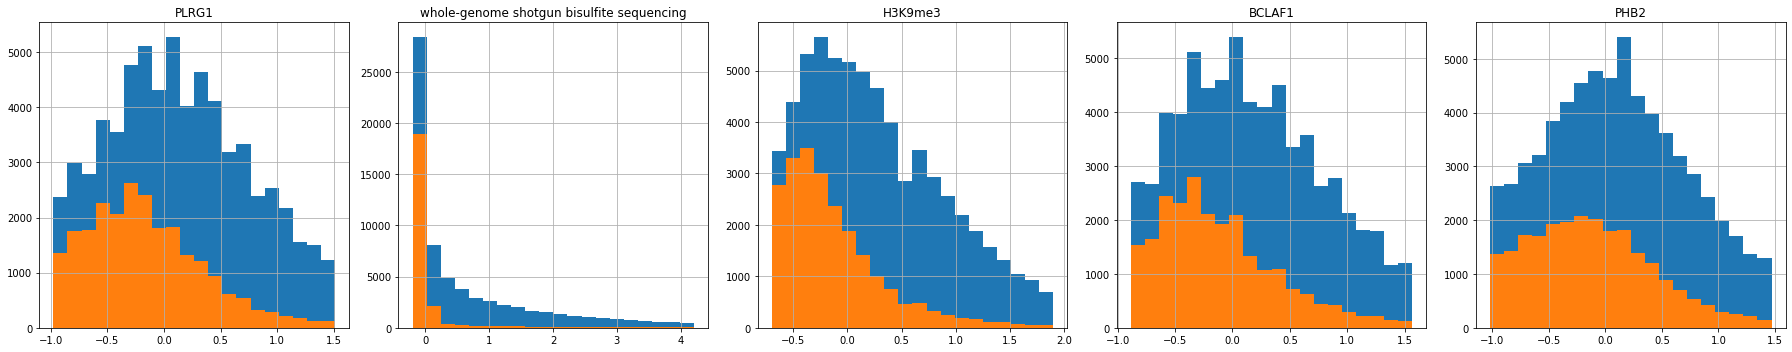

Top 5 different features from enhancers.


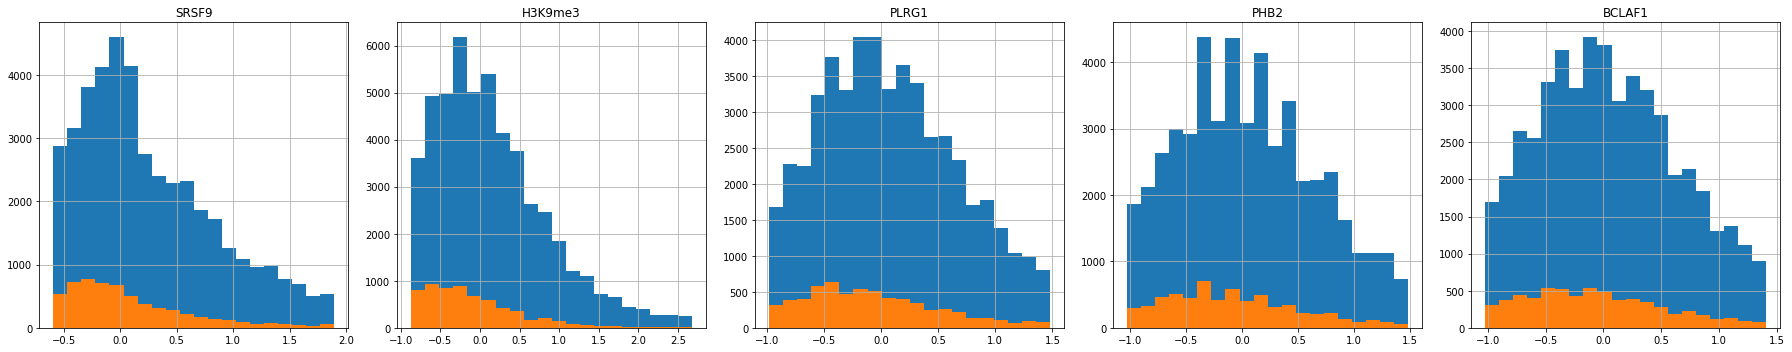

In [ ]:
top_number = 5

for region, x in epigenomes.items():
    dist = cosine_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = binary_labels[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column)
    fig.tight_layout()
    plt.show()

## Distribution of the labels

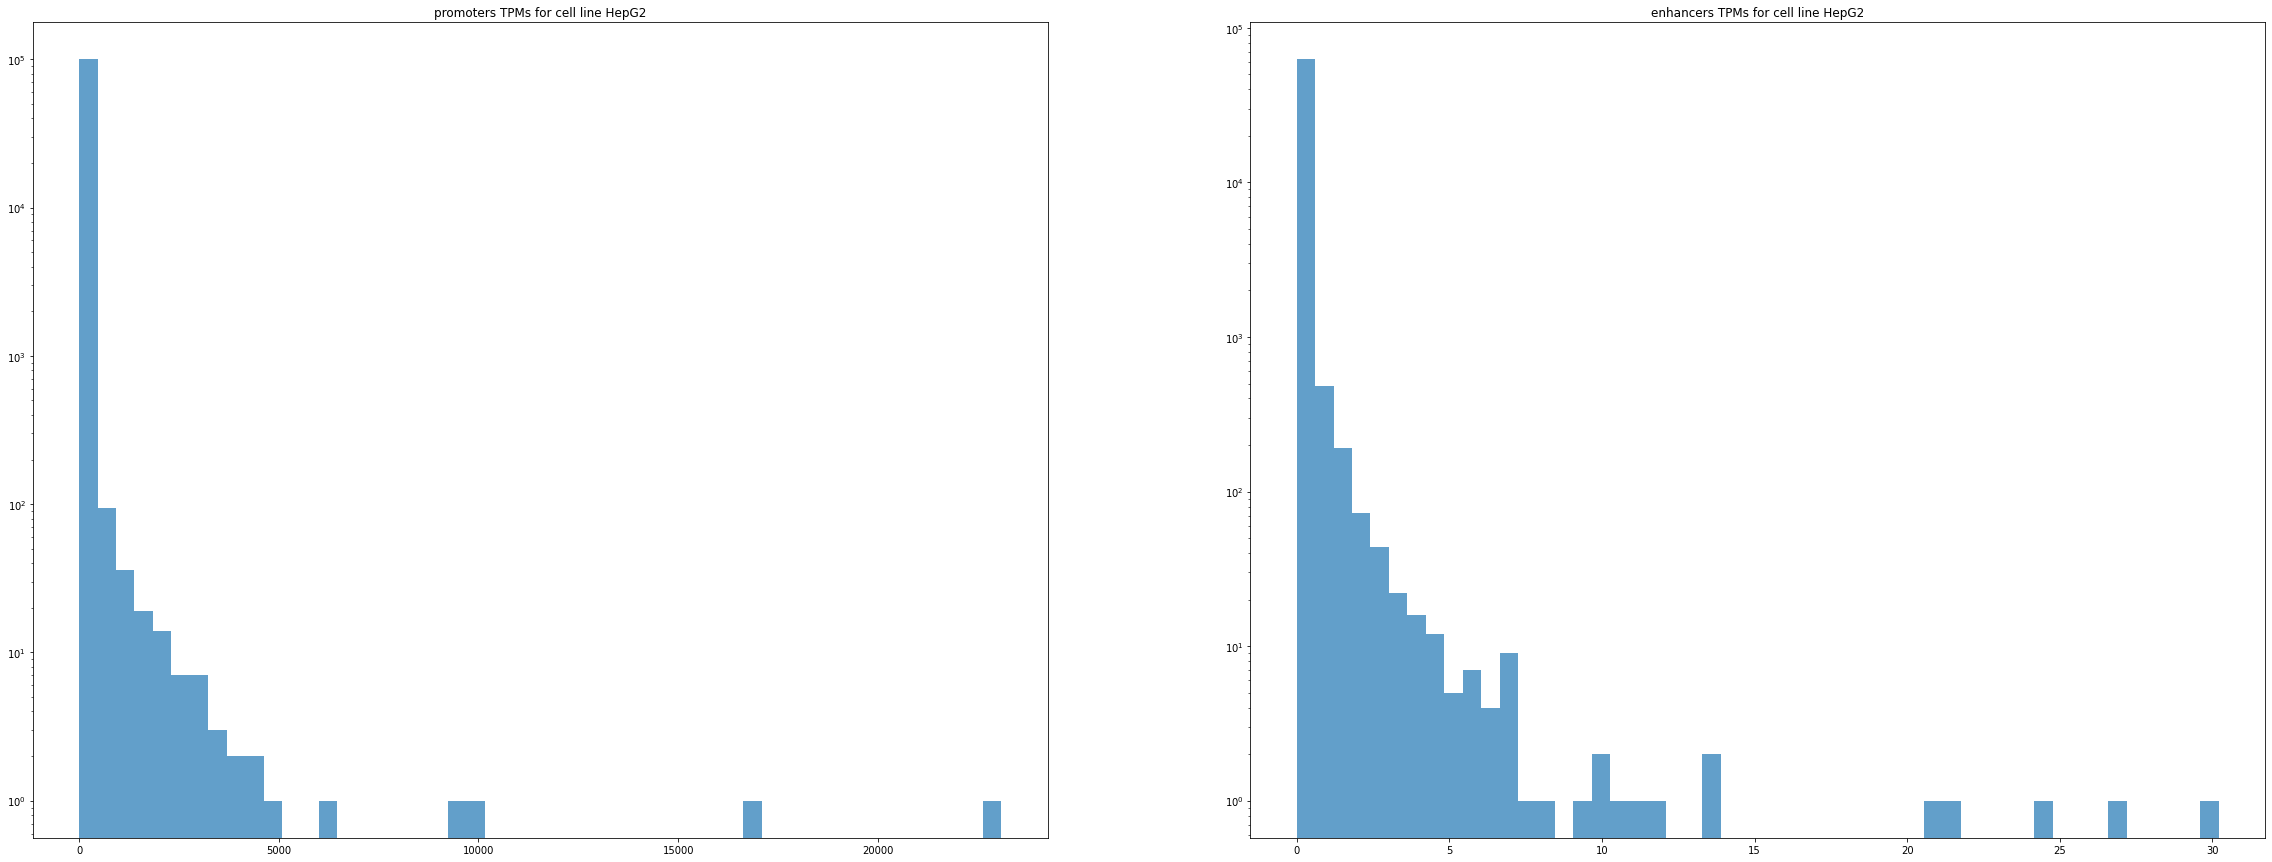

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(40, 15))

for i, (region, x) in enumerate(labels.items()):
    ax[i].hist(
        x.values, 
        bins = 50, 
        alpha = 0.7, 
        label = region,
        log = True
        )
    ax[i].set_title(f"{region} TPMs for {cell_line}")
plt.show()

# Retrieving genomic data

In [7]:
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence 
from keras_mixed_sequence import MixedSequence, VectorSequence

In [8]:
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|               | 0/25 [00:00<?, ?it/s]

In [9]:
temp = epigenomes["enhancers"].reset_index() 
bed = temp[temp.columns[:5]]

In [10]:
sequences = genome.bed_to_sequence(bed)

# Evaluating the possibility of imputation in this case...
sum([
     nucleotide.lower() == 'n'
     for seq in tqdm(sequences)
     for nucleotide in seq
])

  0%|          | 0/63285 [00:00<?, ?it/s]

1

No imputation for two reason: first in sequence data is pretty hard (also near neightbour in this high dimensional data is hard to compute) and becouse there is just one null values

In [11]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# Data visualization throught PCA and t-SNE

In [104]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm

def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str
) -> pd.DataFrame:
    """Return the 2D decomposition of the given data with PCA"""
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )

def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str
) -> pd.DataFrame:
    """Return the 2D decomposition of the given data with t-SNE"""
    return pd.DataFrame(
        TSNE(n_components=2).fit_transform(X.values),
        index=X.index
    )

def impute_values(df, imputer)->pd.DataFrame:
    """Impute null values using the given imputer"""
    return pd.DataFrame(
        imputer.fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [111]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

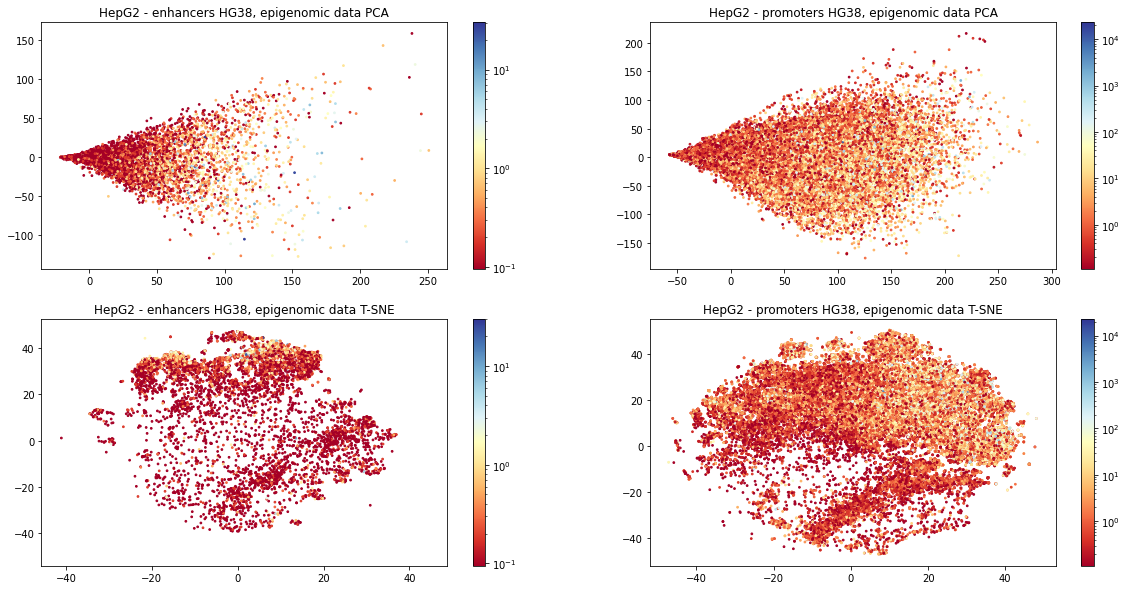

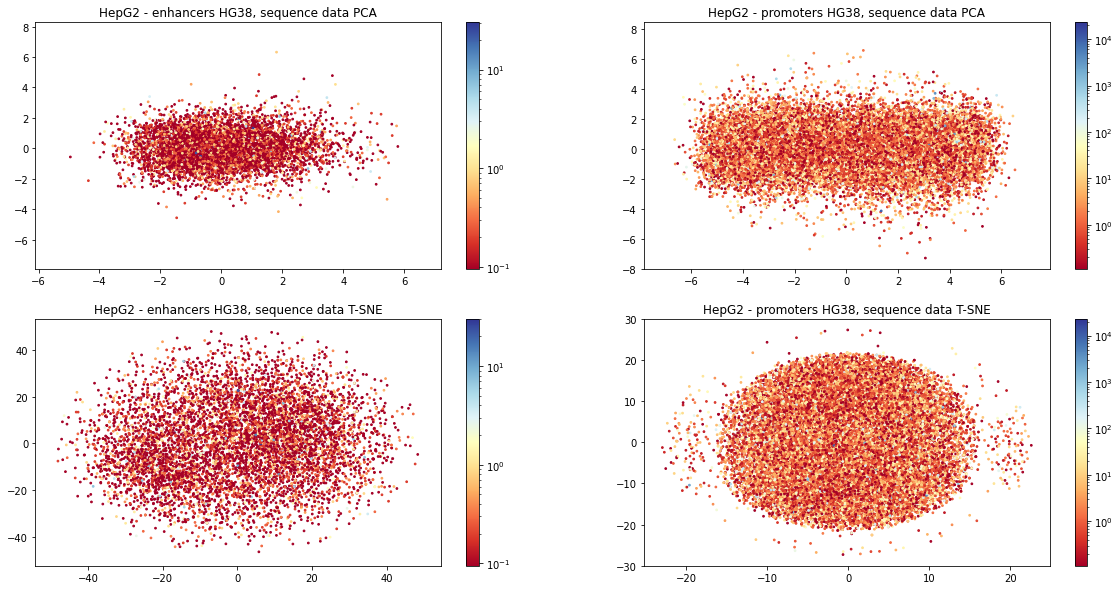

In [79]:
epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize = (20,10),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize = (20,10),
    squeeze=False
)

# use initial data, with just imputation, not scaling...

a = impute_values(X_enh, KNNImputer(n_neighbors=5))
b = impute_values(X_pro, KNNImputer(n_neighbors=5))
for i, (region, x) in enumerate((("enhancers", a), ("promoters", b))): 
    scatter_with_heatmap(
        get_pca_decomposition(x, "epigenomic", region),
        labels[region].values.ravel(), 
        epigenomic_fig, 
        epigenomic_axes[0][i]
    )
    
    epigenomic_axes[0][i].set_title(f"{cell_line} - {region} HG38, epigenomic data PCA")
    #epigenomic_axes[0][i].set_axis_off()
    
    scatter_with_heatmap(
        get_tsne_decomposition(x, "epigenomic", region),
        labels[region].values.ravel(), 
        epigenomic_fig, 
        epigenomic_axes[1][i]
    )
    
    epigenomic_axes[1][i].set_title(f"{cell_line} - {region} HG38, epigenomic data T-SNE")
    
    sequence = pd.DataFrame(
                    np.array(BedSequence(
                        genome,
                        bed=to_bed(labels[region]),
                        batch_size=1
                    )).reshape(-1, 4*256),
                    index=labels[region].index
                )
    decomposed_sequence = get_pca_decomposition(sequence, "sequence",region)
    
    scatter_with_heatmap(
        decomposition=decomposed_sequence,
        scores=labels[region].values.ravel(),
        figure=sequence_fig,
        ax=sequence_axes[0][i]
    )
    sequence_axes[0][i].set_title(f"{cell_line} - {region} HG38, sequence data PCA")
    
    scatter_with_heatmap(
        get_tsne_decomposition(sequence, "sequence", region),
        labels[region].values.ravel(), 
        sequence_fig, 
        sequence_axes[1][i]
    )
    
    sequence_axes[1][i].set_title(f"{cell_line} - {region} HG38, sequence data T-SNE")
    #sequence_axes[0][i].set_axis_off()


# Feature selection algorithms

## Boruta

In [20]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    
    # Build a random forest classifier...
    model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    boruta_selector = BorutaPy(
        model,
        n_estimators='auto',
        verbose=True,
        alpha=0.05, 
        max_iter=max_iter, 
        random_state=42
    )

    boruta_selector.fit(X_train.values, y_train)
    
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    return kept_features, discarded_features

# Backward feature selection

In [81]:
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def execute_backward_fs(X_train, y_train):
    """
    Feature selection based on backward elimination.
    
    Parameters
    -------------------
    X_train: pd.DataFrame
    Train data X
    y_train: pd.DataFrame
    Train target values

    Returns
    -------------------
    set of features selected from the method.
    """
    cols = list(X_train.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X_train[cols]
        X_1 = sm.add_constant(X_1) 
        model = sm.OLS(y_train,X_1).fit()
        p = pd.Series(data = model.pvalues.values[1:],  index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    return selected_features_BE

# Building models

# Grid Search paramters selection

### Decision tree max depth

In [ ]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV( 
    DecisionTreeClassifier(
        min_samples_leaf=100,
    ),
    {"max_depth" : [3, 5, 7, 9]}
)
gs.fit(epigenomes["promoters"], binary_labels["promoters"])

In [ ]:
gs.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

### Random forest number of estimators

In [ ]:
gs = GridSearchCV( 
    RandomForestClassifier(
        class_weight="balanced_subsample",
        max_depth=7,
        min_samples_leaf=100,
        n_jobs=cpu_count(),
        verbose=False
    ),
    {"n_estimators" : [200, 400, 600, 800]}
)
gs.fit(epigenomes["promoters"], binary_labels["promoters"].values.ravel())

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              max_depth=7, min_samples_leaf=100,
                                              n_jobs=20, verbose=False),
             param_grid={'n_estimators': [200, 400, 600, 800]})

In [ ]:
gs.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=100, n_estimators=800, n_jobs=20,
                       verbose=False)

### Adaboost number of estimators

In [ ]:
base = DecisionTreeClassifier(
        max_depth=7,
        min_samples_leaf=100
    )
adaboost = AdaBoostClassifier(
    base_estimator=base,
)
    
gs = GridSearchCV( 
    adaboost,
    {"n_estimators" : [40, 50, 60, 100]} # See bibliography for the choice...
)
gs.fit(epigenomes["promoters"], binary_labels["promoters"].values.ravel())

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7,
                                                                                min_samples_leaf=100)),
             param_grid={'n_estimators': [40, 50, 60, 100]})

In [ ]:
gs.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7,
                                                         min_samples_leaf=100),
                   n_estimators=40)

# Functions to evaluate comparison models

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Dict
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

number_of_splits = 4

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

In [21]:
def evaluate_model_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_true: np.ndarray,
        The ground truth labels.
    y_pred: np.ndarray,
        The predicted labels.
    
    Raises
    ---------------------
    ValueError,
        If the two given numpy arrays do not have the same shape.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    if y_true.shape != y_pred.shape:
        raise ValueError(
            "The two arrays do not have the same shape: {} != {}".format(
                y_true.shape, y_pred.shape
            )
        )
    float_metrics = average_precision_score, roc_auc_score
    int_metrics = (accuracy_score, )
    return {
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        },
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred).astype(int))
            for metric in int_metrics
        }
    }

In [22]:
def evaluate_all_model_prediction(
    y_train_true: np.ndarray,
    y_train_pred: np.ndarray,
    y_test_true: np.ndarray,
    y_test_pred: np.ndarray,
    model_name: str,
    region: str,
    feature_selection_name: str
) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_train_true: np.ndarray,
        Ground truth labels used during training.
    y_train_pred: np.ndarray,
        Training predictions
    y_test_true: np.ndarray,
        Ground truth labels used for test.
    y_test_pred: np.ndarray,
        Test predictions
    model_name: str,
        Name of the model used.
    feature_selection_name: str
        Name 0f the feature selection method used.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    common_informations = {
        "model_name": model_name,
        "region" : region,
        "feature_selection" : feature_selection_name
    }
    return [
        {
            **evaluate_model_prediction(y_train_true, y_train_pred),
            "run_type": "train",
            **common_informations
        },
        {
            **evaluate_model_prediction(y_test_true, y_test_pred),
            "run_type": "test",
            **common_informations
        },
    ]

# Decision Tree and Random Forest

In [23]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    region:str,
    feature_selection_name: str
) -> Dict[str, float]:
    """Return performance of a Decision Tree model.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    feature_selection_name: str
        Name 0f the feature selection method used.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    tree = DecisionTreeClassifier(
        max_depth=7,
        min_samples_leaf=100
    )
    tree.fit(X_train, y_train.ravel())
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "Decision Tree", region, feature_selection_name
    )

In [24]:
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count

def train_random_forest(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    region:str,
    feature_selection_name: str
) -> Dict[str, float]:
    """Return performance of a Random Forest model.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    feature_selection_name: str
        Name 0f the feature selection method used.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    forest = RandomForestClassifier(
        n_estimators=5,
        class_weight="balanced_subsample",
        max_depth=5,
        min_samples_leaf=800,
        n_jobs=cpu_count(),
        verbose=False
    )
    forest.fit(X_train, y_train.ravel())
    y_train_pred = forest.predict(X_train)
    y_test_pred = forest.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "Random Forest", region, feature_selection_name
    )

# Adaboost

In [25]:
from sklearn.ensemble import AdaBoostClassifier

def train_adaboost(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    region: str,
    feature_selection_name: str
) -> Dict[str, float]:
    """Return performance of AdaBoost model.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    feature_selection_name: str
        Name 0f the feature selection method used.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    base = DecisionTreeClassifier(
        max_depth=7,
        min_samples_leaf=100
    )
    adaboost = AdaBoostClassifier(
        base_estimator=base,
        n_estimators=40,
    )
    adaboost.fit(X_train, y_train.ravel())
    y_train_pred = adaboost.predict(X_train)
    y_test_pred = adaboost.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "Adaboost", region, feature_selection_name
    )

# Running feature selections

I've decided to run the feature selection algorithms just once per epigenome region due to performance reason mainly caused by the boruta FS approach. 

In [ ]:
from sklearn.linear_model import ElasticNet
from multiprocessing import cpu_count
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning


kept_features_dict = {"No Feature Selection" : {}, "Boruta" : {}, "Backward" : {}}

for region, x in epigenomes.items():
    kept_features_dict['No Feature Selection'][region] = list(x.columns)
    kept_features_dict["Boruta"][region],_ = execute_boruta_feature_selection(x, binary_labels[region].values.ravel())
    kept_features_dict["Backward"][region] = execute_backward_fs(x, binary_labels[region].values.ravel())

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

/home/alberto/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.377285821226906, tolerance: 1.912696526866474
  model = cd_fast.enet_coordinate_descent(


AttributeError: 'ElasticNet' object has no attribute 'pvalues'

In [ ]:
import pickle 
with open('./pickle/kept-feature-dict.pkl', 'wb') as file:
    pickle.dump(kept_features_dict, file)

In [13]:
import pickle 
with open('./pickle/kept-feature-dict.pkl', 'rb') as file:
    kept_features_dict = pickle.load(file)

## Number of features selected by each approach

In [152]:
for i,j in kept_features_dict.items():
    for region, f in j.items():
        print("region: {}, FS method: {}, number of features: {}".format(region, i, len(f)))

region: promoters, FS method: No Feature Selection, number of features: 547
region: enhancers, FS method: No Feature Selection, number of features: 556
region: promoters, FS method: Boruta, number of features: 493
region: enhancers, FS method: Boruta, number of features: 352
region: promoters, FS method: Backward, number of features: 264
region: enhancers, FS method: Backward, number of features: 151


# Final loop for comparison models

In [28]:
%%time
feature_selection_names = ["No Feature Selection", "Boruta", "Backward"]
all_performance = []

for region, x in epigenomes_test.items():
    for holdout_number, (train_indices, test_indices) in tqdm(
            enumerate(holdouts_generator.split(x, binary_labels_test[region])),
            total=number_of_splits,
            desc=f"Computing holdouts for {region}"
        ):
        
        for feature_selected in tqdm(
            feature_selection_names,
            desc="Computing holdout for feature selection method...", 
            leave=False,
            total=3
            ):
            
            X_train, X_test = x[kept_features_dict[feature_selected][region]].iloc[train_indices], x[kept_features_dict[feature_selected][region]].iloc[test_indices]
            y_train, y_test = binary_labels[region].iloc[train_indices], binary_labels[region].iloc[test_indices]

            for model in tqdm(
                (train_decision_tree, train_random_forest, train_adaboost),
                desc = "Training models",
                total = 3
            ):
                performance = model(
                    X_train.values, X_test.values, y_train.values, y_test.values, region, feature_selected
                )
                all_performance += performance
                
all_performance = pd.DataFrame(all_performance)

Computing holdouts for promoters:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdouts for enhancers:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 2.09 s, sys: 143 ms, total: 2.24 s
Wall time: 2.13 s


In [27]:
%%time
feature_selection_names = ["No Feature Selection", "Boruta", "Backward"]
all_performance = []

for region, x in epigenomes.items():
    for holdout_number, (train_indices, test_indices) in tqdm(
            enumerate(holdouts_generator.split(x, binary_labels[region])),
            total=number_of_splits,
            desc=f"Computing holdouts for {region}"
        ):
        
        for feature_selected in tqdm(
            feature_selection_names,
            desc="Computing holdout for feature selection method...", 
            leave=False,
            total=3
            ):
            
            X_train, X_test = x[kept_features_dict[feature_selected][region]].iloc[train_indices], x[kept_features_dict[feature_selected][region]].iloc[test_indices]
            y_train, y_test = binary_labels[region].iloc[train_indices], binary_labels[region].iloc[test_indices]

            for model in tqdm(
                (train_decision_tree, train_random_forest, train_adaboost),
                desc = "Training models",
                total = 3
            ):
                performance = model(
                    X_train.values, X_test.values, y_train.values, y_test.values, region, feature_selected
                )
                all_performance += performance
                
all_performance = pd.DataFrame(all_performance)

Computing holdouts for promoters:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdouts for enhancers:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdout for feature selection method...:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 2.04 s, sys: 117 ms, total: 2.16 s
Wall time: 2.05 s


In [ ]:
all_performance

AUPRC     AUROC  Accuracy run_type     model_name     region  \
0    0.579737  0.817433  0.846553    train  Decision Tree  promoters   
1    0.550337  0.797719  0.833158     test  Decision Tree  promoters   
2    0.540694  0.827217  0.805341    train  Random Forest  promoters   
3    0.538755  0.825147  0.804725     test  Random Forest  promoters   
4    0.761492  0.902142  0.922657    train       Adaboost  promoters   
..        ...       ...       ...      ...            ...        ...   
139  0.334824  0.669851  0.912460     test  Decision Tree  enhancers   
140  0.276115  0.763335  0.818282    train  Random Forest  enhancers   
141  0.256611  0.743612  0.811014     test  Random Forest  enhancers   
142  0.759153  0.894181  0.969503    train       Adaboost  enhancers   
143  0.293058  0.682114  0.895947     test       Adaboost  enhancers   

        feature_selection  
0    No Feature Selection  
1    No Feature Selection  
2    No Feature Selection  
3    No Feature Selection  
4    No Feature Selection  
..                    ...  
139              Backward  
140              Backward  
141              Backward  
142              Backward  
143              Backward  

[144 rows x 7 columns]

Rendering barplots:   0%|                                 | 0/3 [00:00<?, ?it/s]

((<Figure size 3200x1500 with 2 Axes>,
  <Figure size 3200x1500 with 2 Axes>,
  <Figure size 3200x1500 with 2 Axes>),
 (array([<AxesSubplot:title={'center':'Enhancers'}, xlabel='AUROC'>,
         <AxesSubplot:title={'center':'Promoters'}, xlabel='AUROC'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'Enhancers'}, xlabel='Accuracy'>,
         <AxesSubplot:title={'center':'Promoters'}, xlabel='Accuracy'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'Enhancers'}, xlabel='AUPRC'>,
         <AxesSubplot:title={'center':'Promoters'}, xlabel='AUPRC'>],
        dtype=object)))

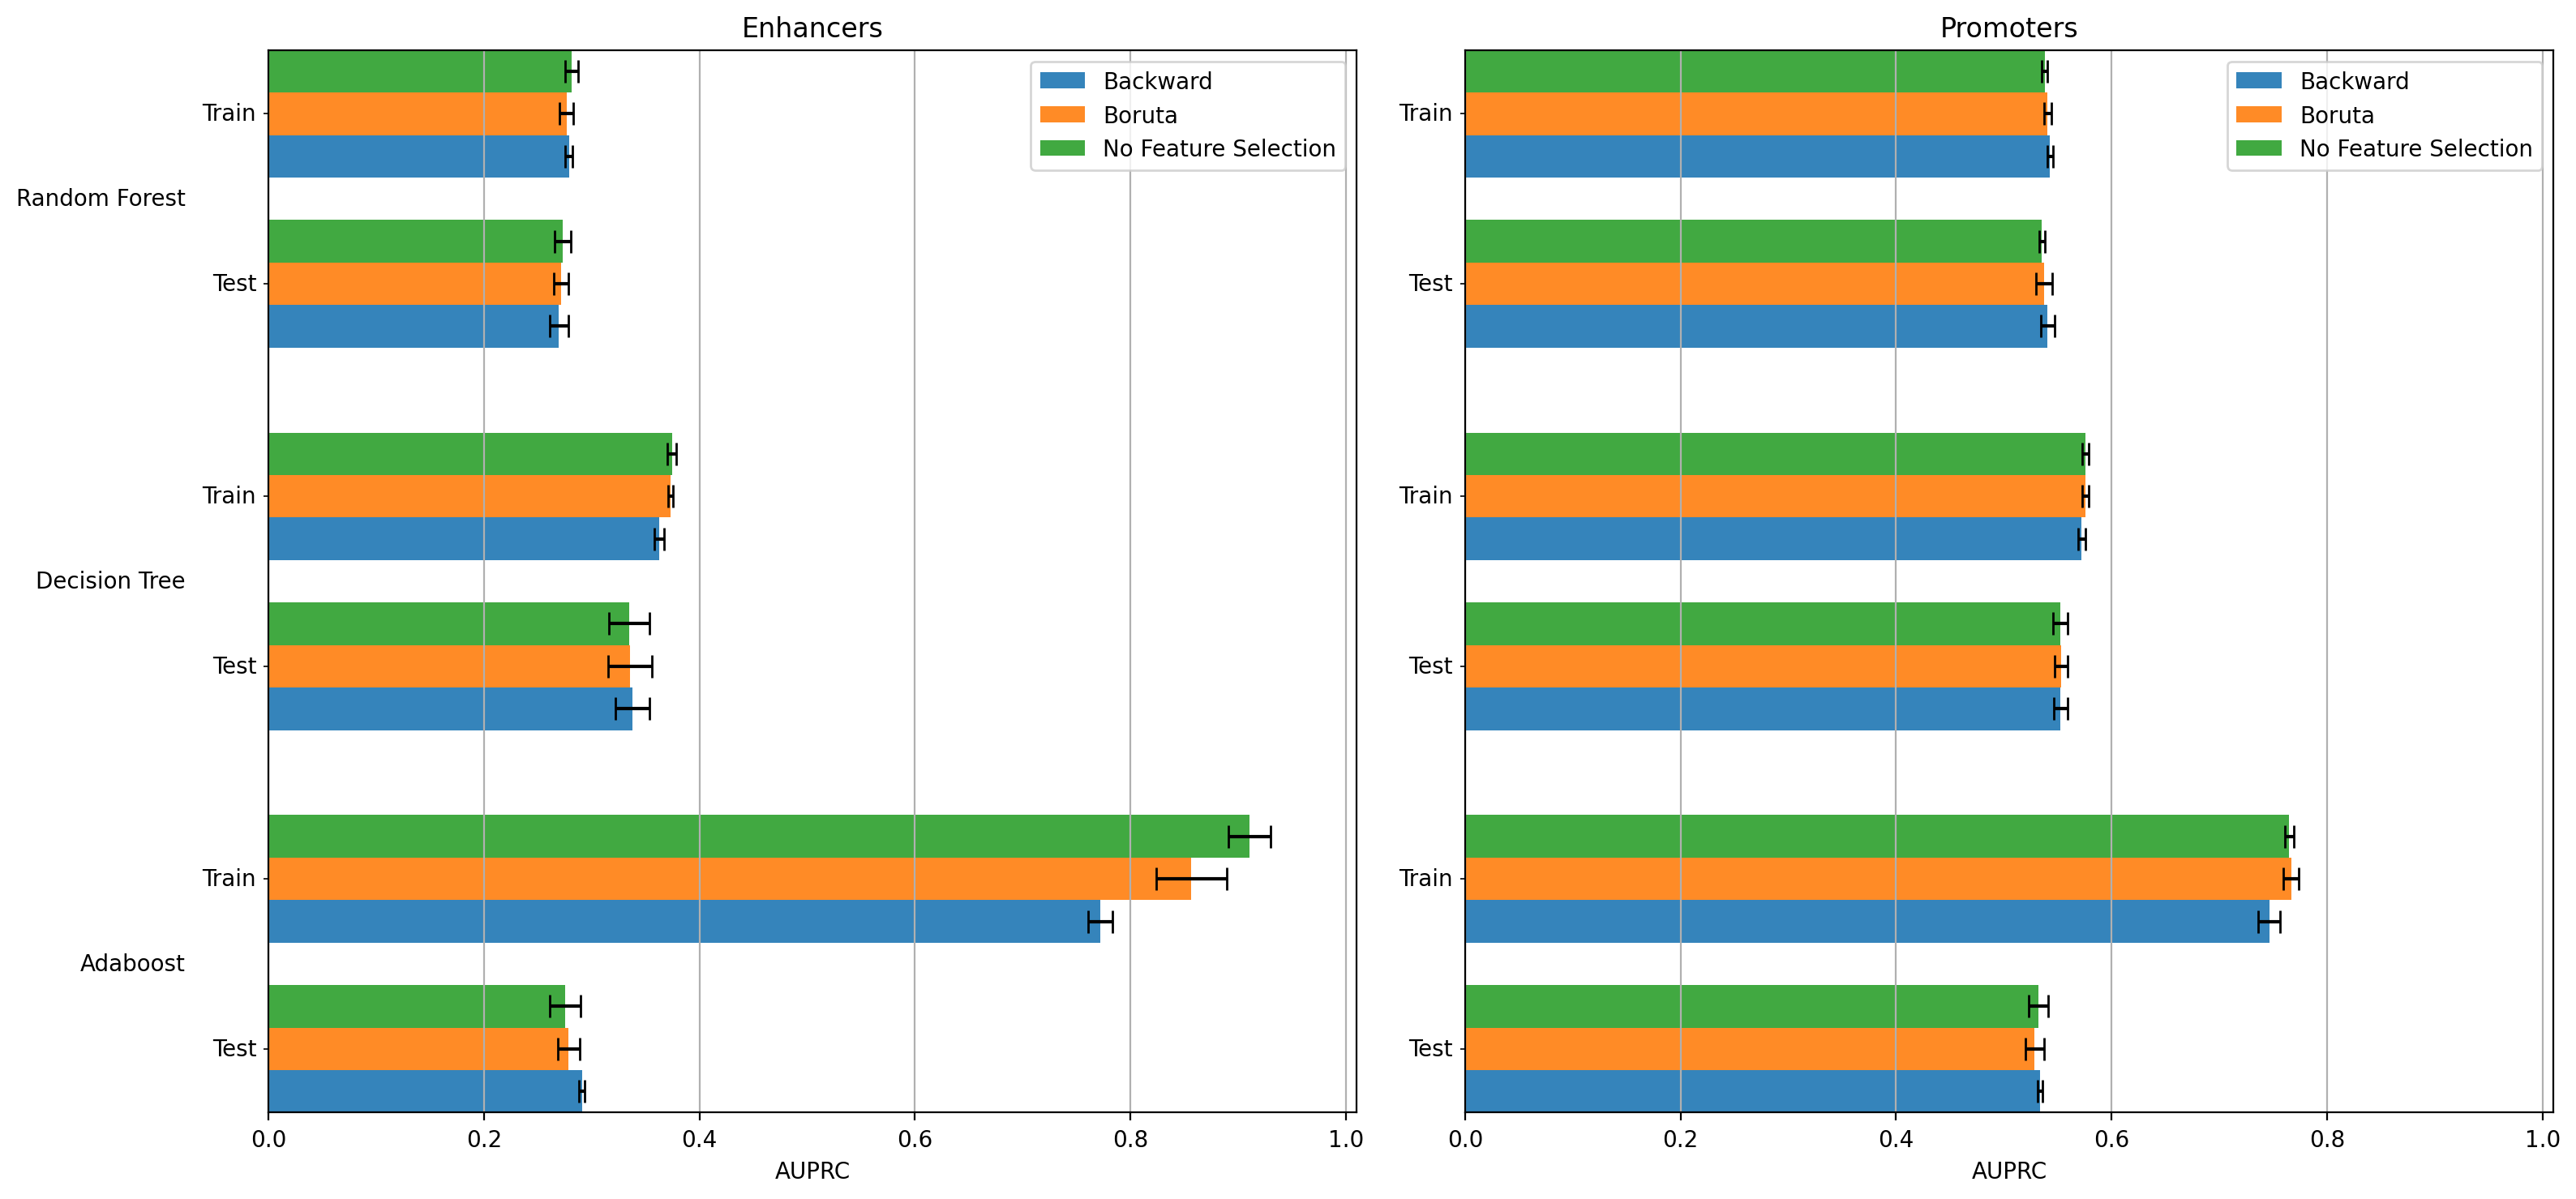

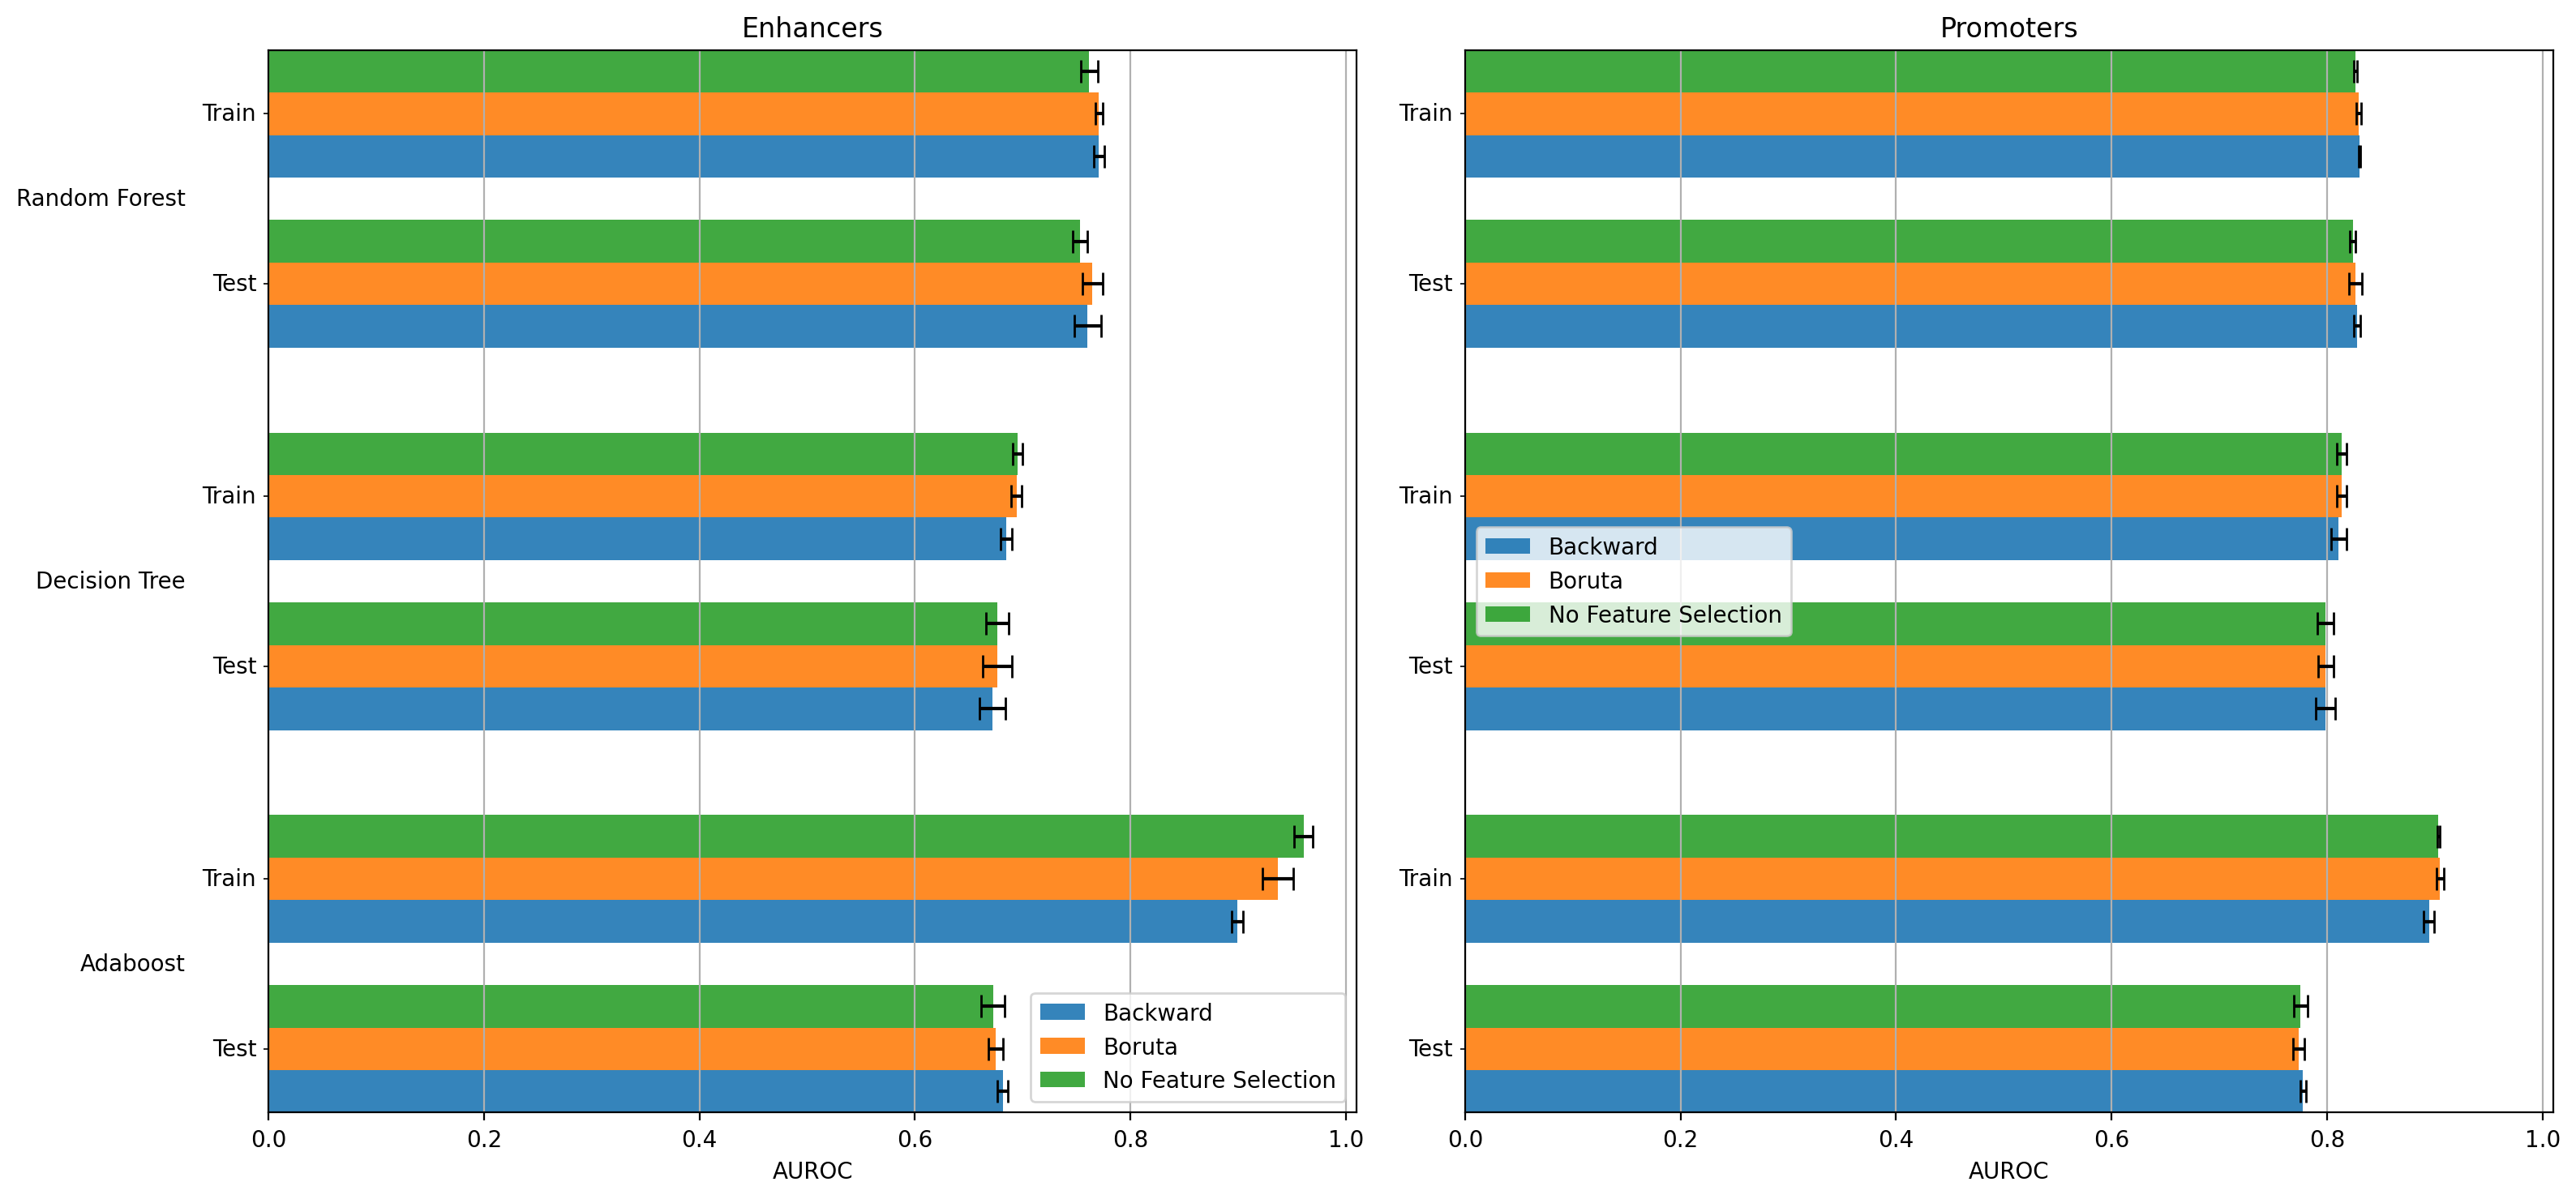

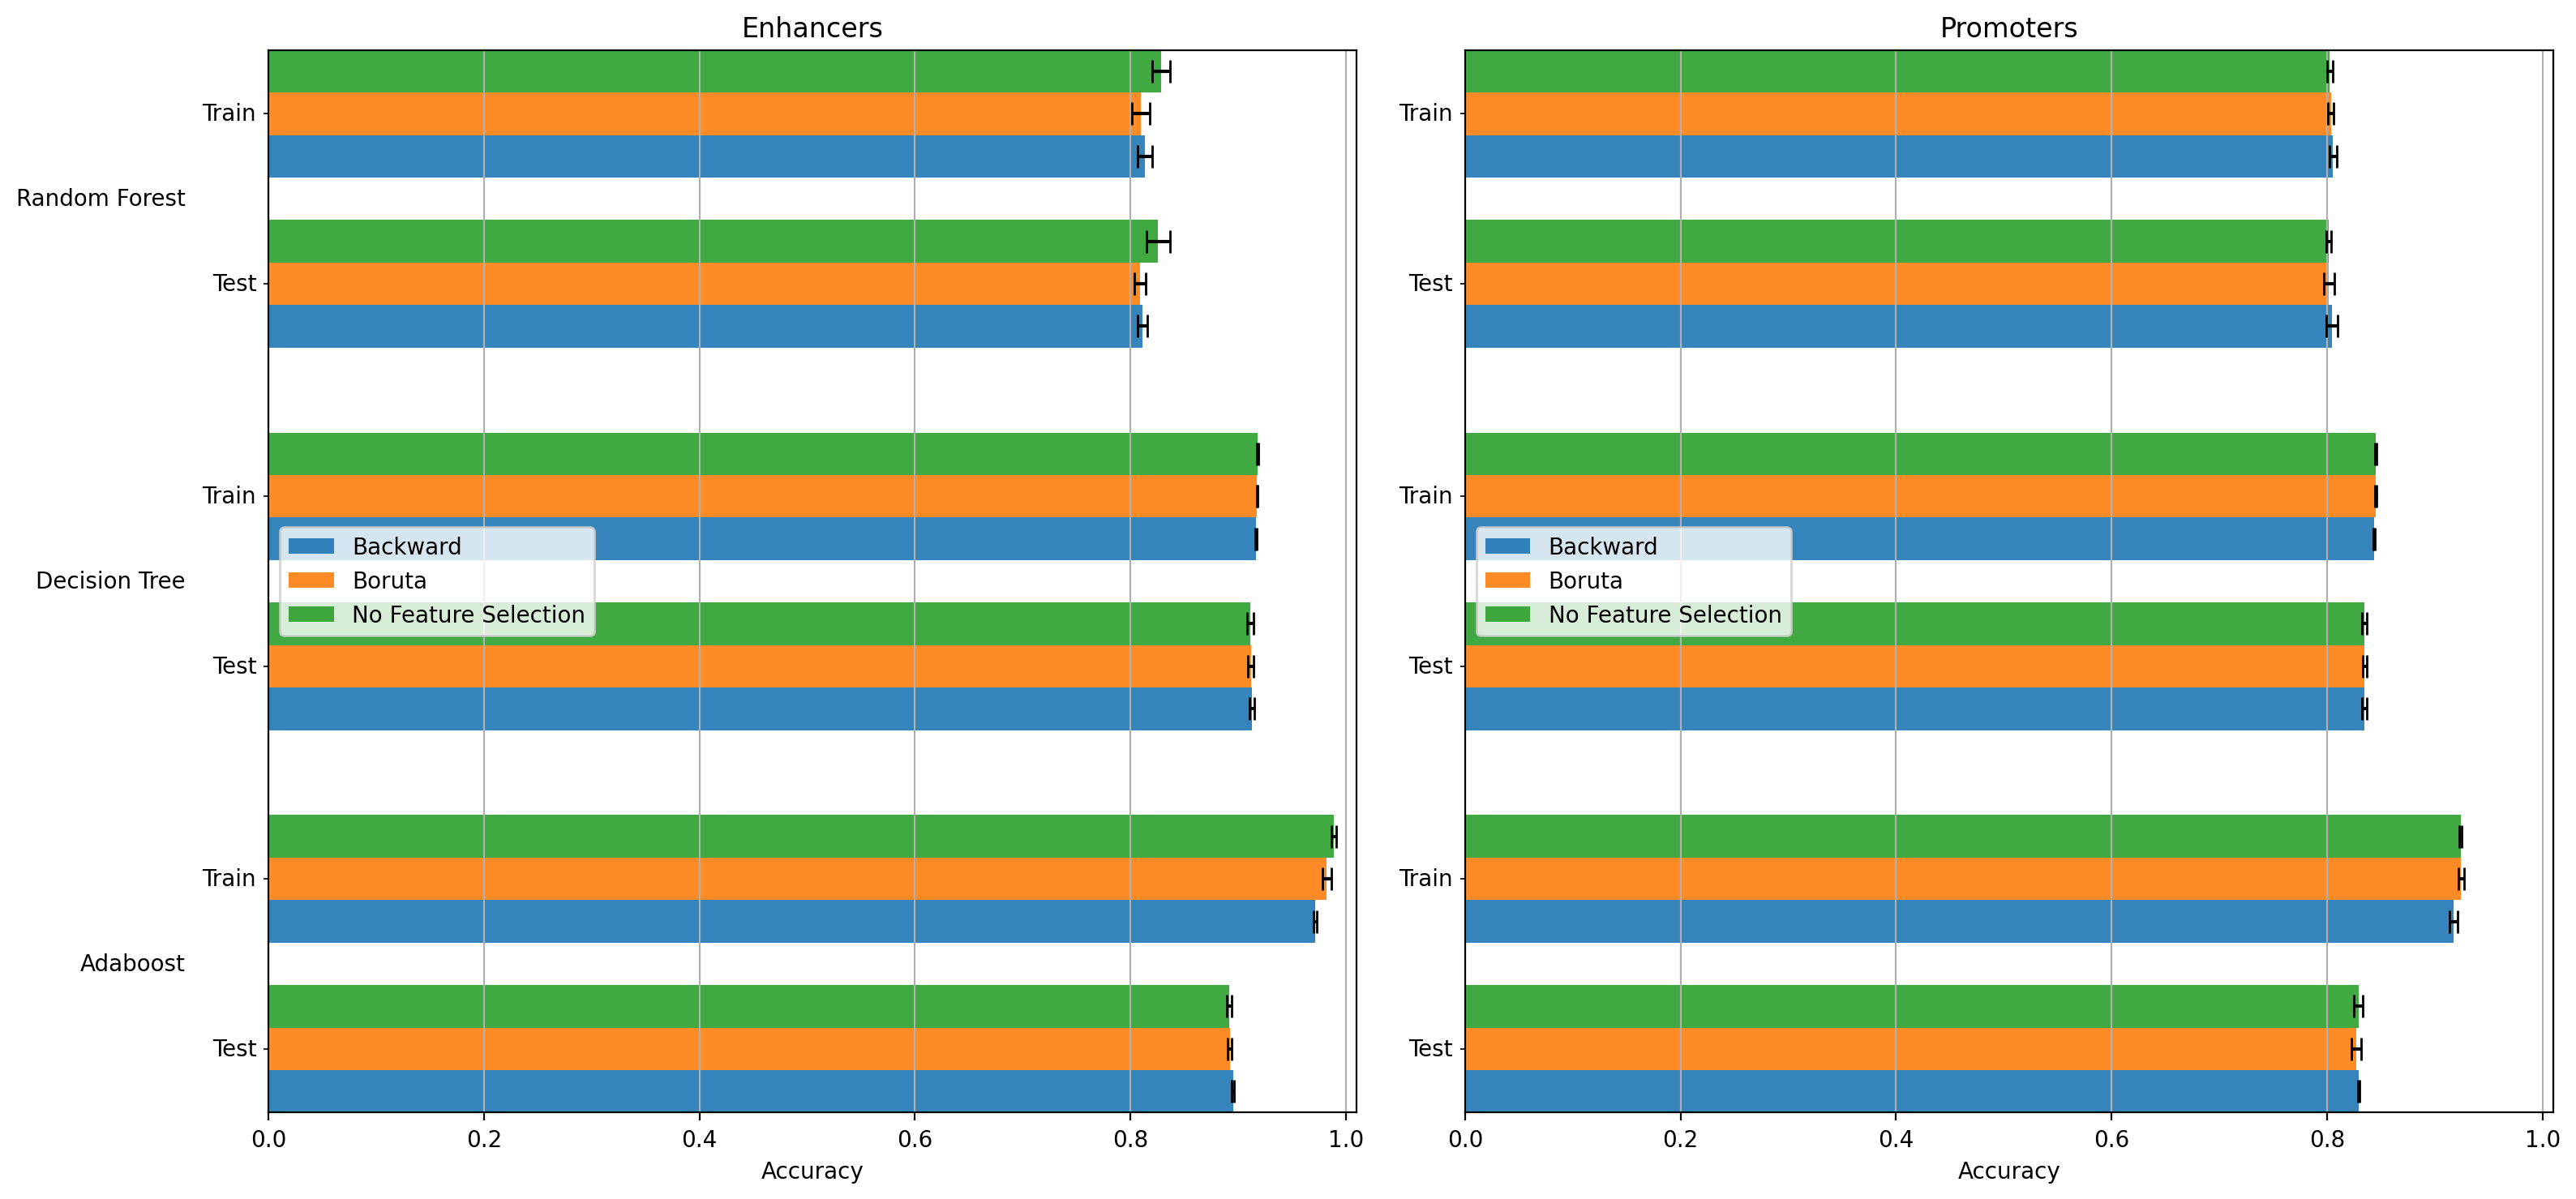

In [ ]:
barplots(
    all_performance,
    groupby=["region", "model_name", "run_type", "feature_selection"],
    orientation="horizontal",
    height=8,
    subplots = True
)

# Neural Network approach

In [14]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, Conv2D,Reshape, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_minimal_multiclass_metrics, get_complete_binary_metrics, get_standard_binary_metrics
from tensorflow.keras.callbacks import EarlyStopping

## FFNN

In [15]:
def build_ffnn(
    input_shape: int
) -> Tuple[Model, Layer, Layer]:
    """Returns FeedForward Neural Network model, inpout and output layer.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    #
    hidden = Dense(64, activation="relu")(input_epigenomic_data)
    hidden = Dense(32, activation="relu")(hidden)
    hidden = Dense(16, activation="relu")(hidden)
    
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="FFNN"
    )

    ffnn.compile(
        optimizer=SGD(learning_rate=0.5, decay = 0.01),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )
    
    return ffnn, input_epigenomic_data, last_hidden_ffnn

# CNN

In [52]:
def build_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model, inpout and output layer.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    
    # Three layers of CONV1D with batch normalization
    
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)
    hidden = BatchNormalization()(hidden)
    
    hidden = MaxPool1D(pool_size = 2)(hidden)
    
    hidden = Conv1D(64, kernel_size=10, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)

    hidden = MaxPool1D(pool_size = 2)(hidden)
    
    hidden = Flatten()(hidden)
    hidden = Dense(64, activation = "relu")(hidden)
    hidden = Dropout(0.2)(hidden)
    hidden = Dense(64, activation = "relu")(hidden)
    
    last_hidden_cnn = Dropout(0.1)(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)
    
    
    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="CNN"
    )

    cnn.compile(
        optimizer=Nadam(learning_rate=0.002),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

# MMNN

In [17]:
# from embracenet_tf2 import EmbraceNet

def build_mmnn(
    input_epigenomic_data: Layer,
    input_sequence_data: Layer,
    last_hidden_ffnn: Layer,
    last_hidden_cnn: Layer
):
    """
    Returns Multi-Modal Neural Network model for binary classification.
    
     Parameters
    -----------------------
    input_epigenomic_data: Layer,
        Input for the epigenomic data from the FFNN model.
    input_sequence_data: Layer,
        Input for the sequence data from the CNN model.
    last_hidden_ffnn: Layer,
        Last layer from the FFNN model. 
    last_hidden_cnn: Layer,
        Last layer from the CNN model.
    """
    # Concatenation layer        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    
    
    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )
    
    return mmnn

# Retrieve the sequences

In [18]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.

    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

# Train the models

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(
    model: Model,
    model_name: str,
    region: str,
    feature_selection_name: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    region: str,
        region name (enhancer or promoters).
    feature_selection_name: str,
        name of the feature selection method used,
    train_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
            # TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=True)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["region"] = region
        evaluation["feature_selection"] = feature_selection_name
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

# Evaluation of the NN models

In [34]:
epigenomes_sorted = {k: v for k, v in sorted(epigenomes.items(), key=lambda item: item[0])}

In [35]:
%%time

import tensorflow.keras.backend as backend

all_performance = []
feature_selection_names = ["No Feature Selection", "Boruta", "Backward"]
training_histories = {}

window_size = 256
# For enhancers and promoters...
for region, x in epigenomes_sorted.items():
    training_histories[region] = []
    bed = to_bed(x)
    for holdout_number, (train_indices, test_indices) in tqdm(
          enumerate(holdouts_generator.split(x, binary_labels[region])),
          total=number_of_splits,
          desc=f"Computing holdouts for {region}"
    ):
        for feature_selected in tqdm(
            feature_selection_names,
            desc="Computing holdout for feature selection method", 
            leave=False,
            total=3
            ):
            
            X_train, X_test = x[kept_features_dict[feature_selected][region]].iloc[train_indices], x[kept_features_dict[feature_selected][region]].iloc[test_indices]
            y_train, y_test = binary_labels[region].iloc[train_indices].values.ravel(), binary_labels[region].iloc[test_indices].values.ravel()
            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            
            ffnn, input_epigenomic_data, last_hidden_ffnn = build_ffnn(X_train.shape[1])
            cnn, input_sequence_data, last_hidden_cnn = build_cnn(window_size)
            mmnn = build_mmnn(input_epigenomic_data, input_sequence_data, last_hidden_ffnn, last_hidden_cnn)
            for model, train_sequence, test_sequence in tqdm(
                (
                    (ffnn, get_ffnn_sequence(X_train.values, y_train), get_ffnn_sequence(X_test.values, y_test)),
                    (cnn, get_cnn_sequence(genome, train_bed, y_train), get_cnn_sequence(genome, test_bed, y_test)),
                    (mmnn, get_mmnn_sequence(genome, train_bed, X_train.values, y_train), get_mmnn_sequence(genome, test_bed, X_test.values, y_test))
                ),
                desc=f"Training models",
                leave=False
                ):
                
                backend.clear_session()
                
                history, performance = train_model(
                    model,
                    model.name,
                    region,
                    feature_selected, # feature_selection_model,
                    train_sequence,
                    test_sequence
                )
                training_histories[region].append(history)
                all_performance.append(performance)
    
all_performance = pd.concat(all_performance)

Computing holdouts for enhancers:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 33ms/step - loss: 1.1464 - accuracy: 0.8848 - recall: 0.1073 - precision: 0.4653 - AUROC: 0.5867 - AUPRC: 0.2206


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 34ms/step - loss: 0.9538 - accuracy: 0.8813 - recall: 0.1268 - precision: 0.4223 - AUROC: 0.6061 - AUPRC: 0.2324


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 32ms/step - loss: 1.0339 - accuracy: 0.8804 - recall: 0.1505 - precision: 0.4227 - AUROC: 0.6273 - AUPRC: 0.2637


Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 35ms/step - loss: 0.8233 - accuracy: 0.8785 - recall: 0.1784 - precision: 0.4163 - AUROC: 0.6386 - AUPRC: 0.2566


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 34ms/step - loss: 1.0072 - accuracy: 0.8745 - recall: 0.1735 - precision: 0.3819 - AUROC: 0.6144 - AUPRC: 0.2391


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 32ms/step - loss: 1.2789 - accuracy: 0.8852 - recall: 0.1303 - precision: 0.4770 - AUROC: 0.5996 - AUPRC: 0.2488


Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 36ms/step - loss: 0.9823 - accuracy: 0.8792 - recall: 0.1833 - precision: 0.4242 - AUROC: 0.6256 - AUPRC: 0.2552


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 34ms/step - loss: 1.0397 - accuracy: 0.8805 - recall: 0.1449 - precision: 0.4219 - AUROC: 0.6050 - AUPRC: 0.2370


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 32ms/step - loss: 1.1818 - accuracy: 0.8784 - recall: 0.1080 - precision: 0.3744 - AUROC: 0.5822 - AUPRC: 0.2046


Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 35ms/step - loss: 1.2229 - accuracy: 0.8797 - recall: 0.0997 - precision: 0.3824 - AUROC: 0.5918 - AUPRC: 0.2108


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 34ms/step - loss: 1.1493 - accuracy: 0.8863 - recall: 0.1101 - precision: 0.4938 - AUROC: 0.6045 - AUPRC: 0.2403


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

13/13 [==============================] - 0s 33ms/step - loss: 0.9477 - accuracy: 0.8843 - recall: 0.1303 - precision: 0.4640 - AUROC: 0.6262 - AUPRC: 0.2483


Computing holdouts for promoters:   0%|          | 0/4 [00:00<?, ?it/s]

Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 36ms/step - loss: 1.0660 - accuracy: 0.7759 - recall: 0.4702 - precision: 0.5817 - AUROC: 0.7635 - AUPRC: 0.5458


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 37ms/step - loss: 1.0878 - accuracy: 0.7793 - recall: 0.4276 - precision: 0.6023 - AUROC: 0.7561 - AUPRC: 0.5382


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 35ms/step - loss: 1.1220 - accuracy: 0.7799 - recall: 0.4334 - precision: 0.6024 - AUROC: 0.7618 - AUPRC: 0.5524


Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 36ms/step - loss: 1.0439 - accuracy: 0.7857 - recall: 0.4365 - precision: 0.6208 - AUROC: 0.7739 - AUPRC: 0.5625


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 36ms/step - loss: 0.9685 - accuracy: 0.7961 - recall: 0.4838 - precision: 0.6388 - AUROC: 0.7903 - AUPRC: 0.5869


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 34ms/step - loss: 0.9508 - accuracy: 0.7796 - recall: 0.4619 - precision: 0.5940 - AUROC: 0.7755 - AUPRC: 0.5546


Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 36ms/step - loss: 1.1630 - accuracy: 0.7819 - recall: 0.4196 - precision: 0.6134 - AUROC: 0.7561 - AUPRC: 0.5424


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 38ms/step - loss: 1.0780 - accuracy: 0.7818 - recall: 0.4848 - precision: 0.5951 - AUROC: 0.7708 - AUPRC: 0.5538


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 35ms/step - loss: 1.1454 - accuracy: 0.7802 - recall: 0.4266 - precision: 0.6056 - AUROC: 0.7594 - AUPRC: 0.5464


Computing holdout for feature selection method:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 38ms/step - loss: 1.4107 - accuracy: 0.7808 - recall: 0.3870 - precision: 0.6212 - AUROC: 0.7383 - AUPRC: 0.5448


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 37ms/step - loss: 1.1612 - accuracy: 0.7817 - recall: 0.4472 - precision: 0.6043 - AUROC: 0.7602 - AUPRC: 0.5454


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

20/20 [==============================] - 1s 36ms/step - loss: 1.0863 - accuracy: 0.7894 - recall: 0.5183 - precision: 0.6081 - AUROC: 0.7846 - AUPRC: 0.5687
CPU times: user 2d 5h 51min 36s, sys: 4h 18min 37s, total: 2d 10h 10min 13s
Wall time: 3h 29min 4s


In [142]:
all_performance

accuracy    recall  precision     AUROC     AUPRC run_type model_name  \
0   0.920439  0.404389   0.792491  0.893222  0.658111    train       FFNN   
1   0.913171  0.359582   0.741379  0.833118  0.568214     test       FFNN   
0   0.997175  0.975792   0.999287  0.999966  0.999759    train        CNN   
1   0.866319  0.056446   0.193317  0.525755  0.132803     test        CNN   
0   0.999506  0.995820   0.999825  1.000000  0.999998    train       MMNN   
..       ...       ...        ...       ...       ...      ...        ...   
1   0.840617  0.697111   0.689093  0.903381  0.716064     test       FFNN   
0   0.989900  0.978182   0.982612  0.999091  0.997349    train        CNN   
1   0.721680  0.367462   0.451944  0.675375  0.424524     test        CNN   
0   0.997197  0.994182   0.994954  0.999925  0.999751    train       MMNN   
1   0.789408  0.518325   0.608053  0.784639  0.568733     test       MMNN   

       region     feature_selection  
0   enhancers  No Feature Selection  
1   enhancers  No Feature Selection  
0   enhancers  No Feature Selection  
1   enhancers  No Feature Selection  
0   enhancers  No Feature Selection  
..        ...                   ...  
1   promoters              Backward  
0   promoters              Backward  
1   promoters              Backward  
0   promoters              Backward  
1   promoters              Backward  

[144 rows x 9 columns]

Rendering barplots:   0%|                                 | 0/5 [00:00<?, ?it/s]

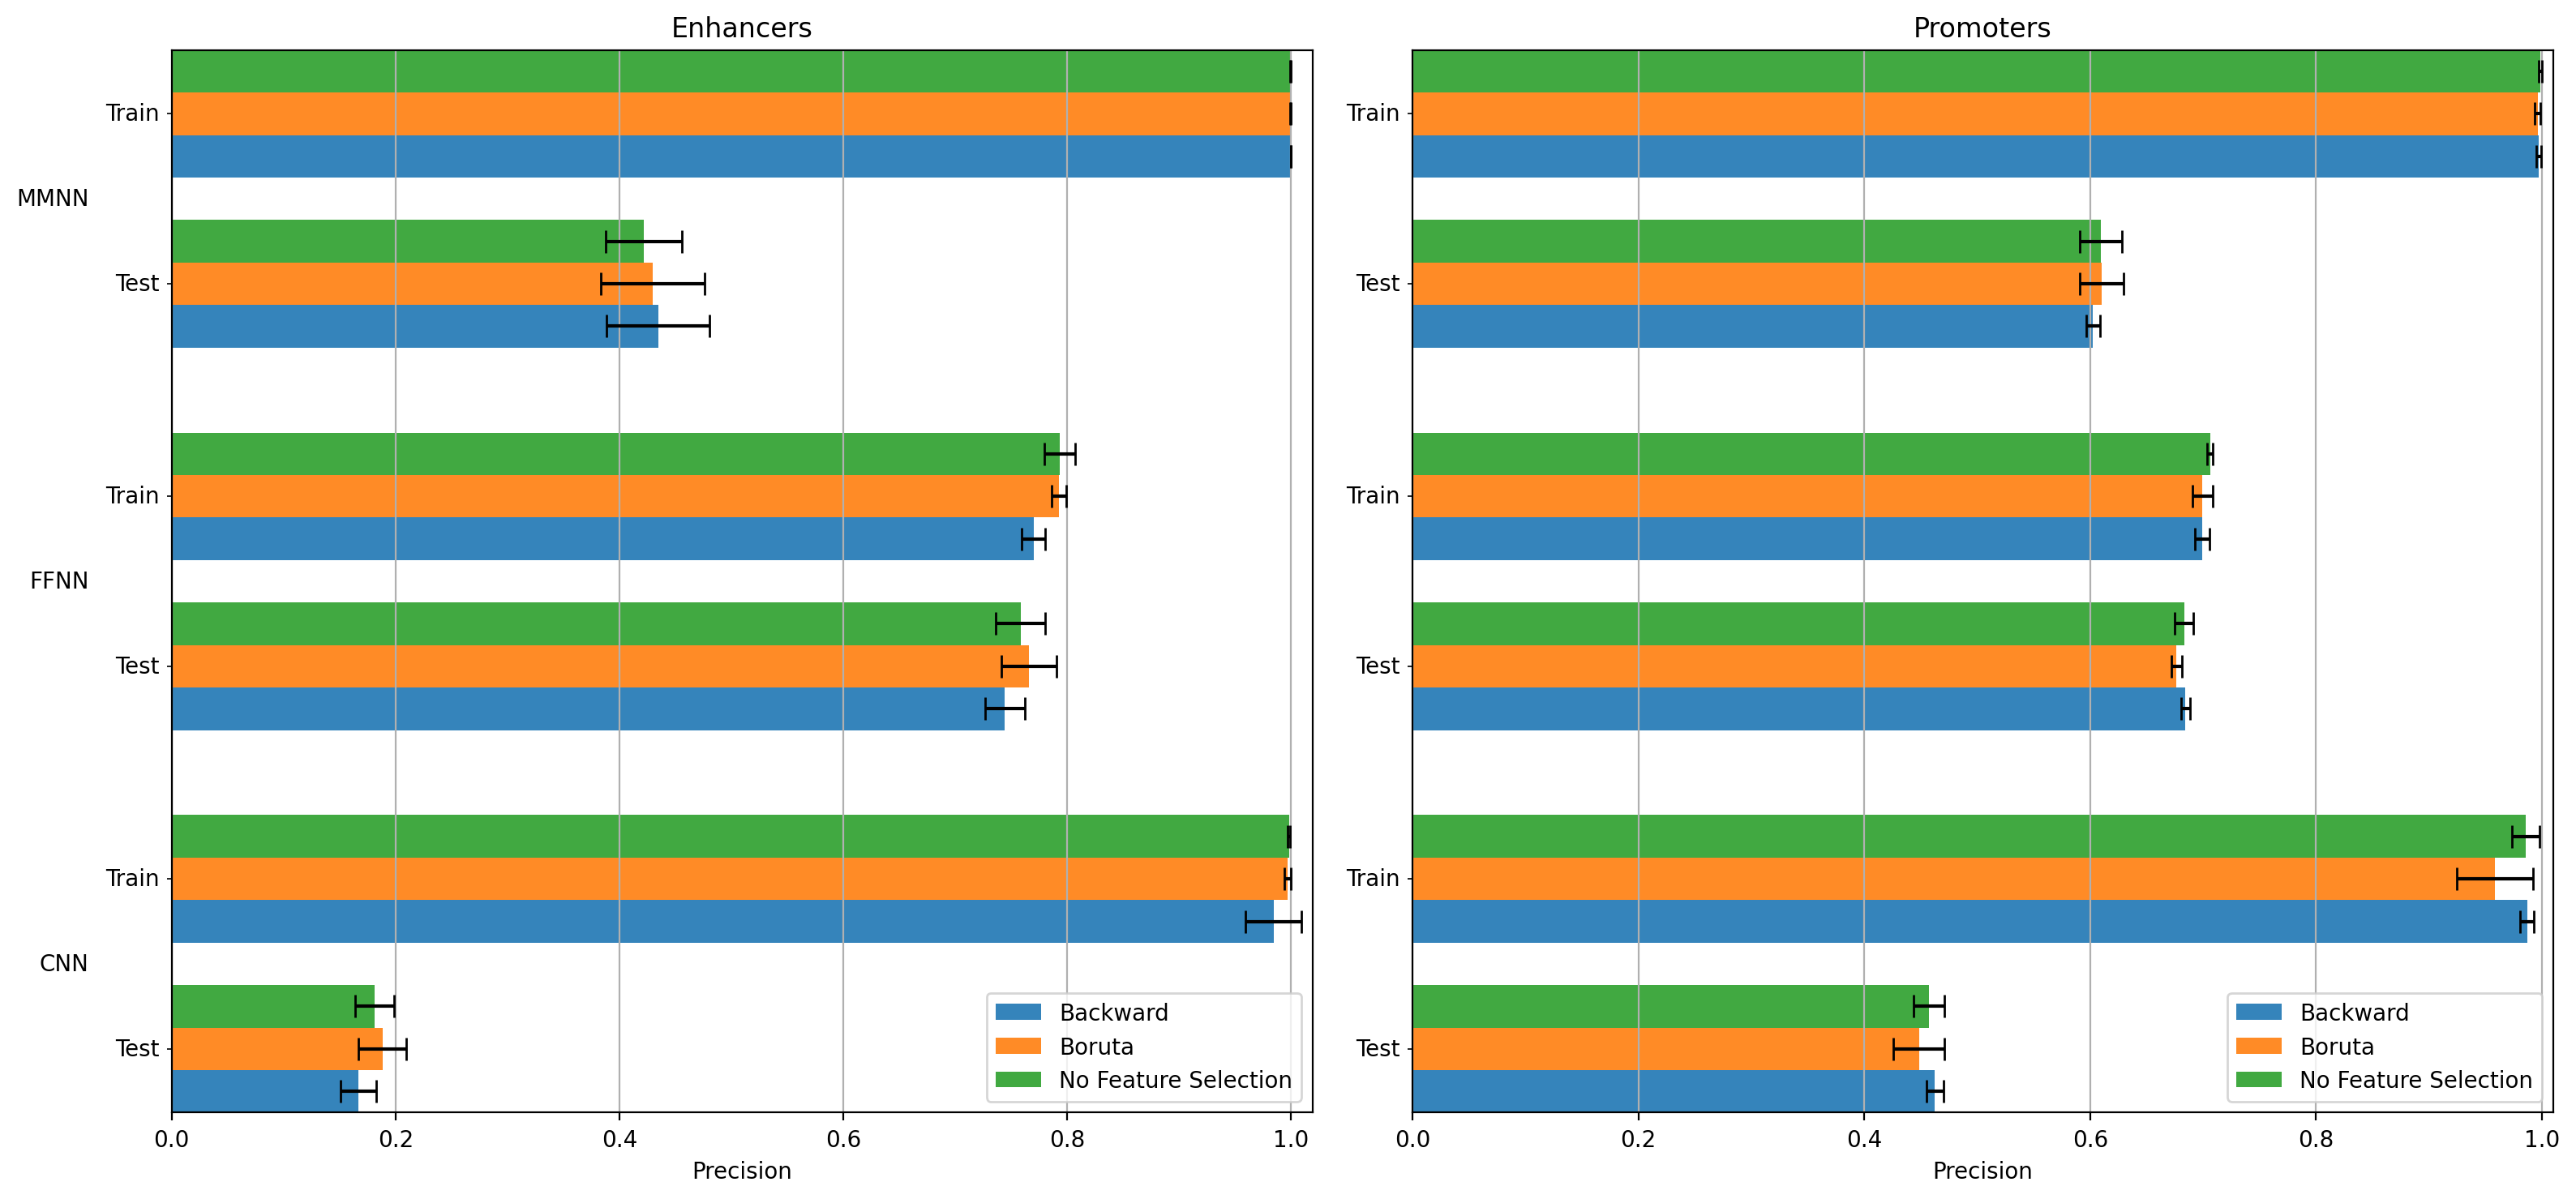

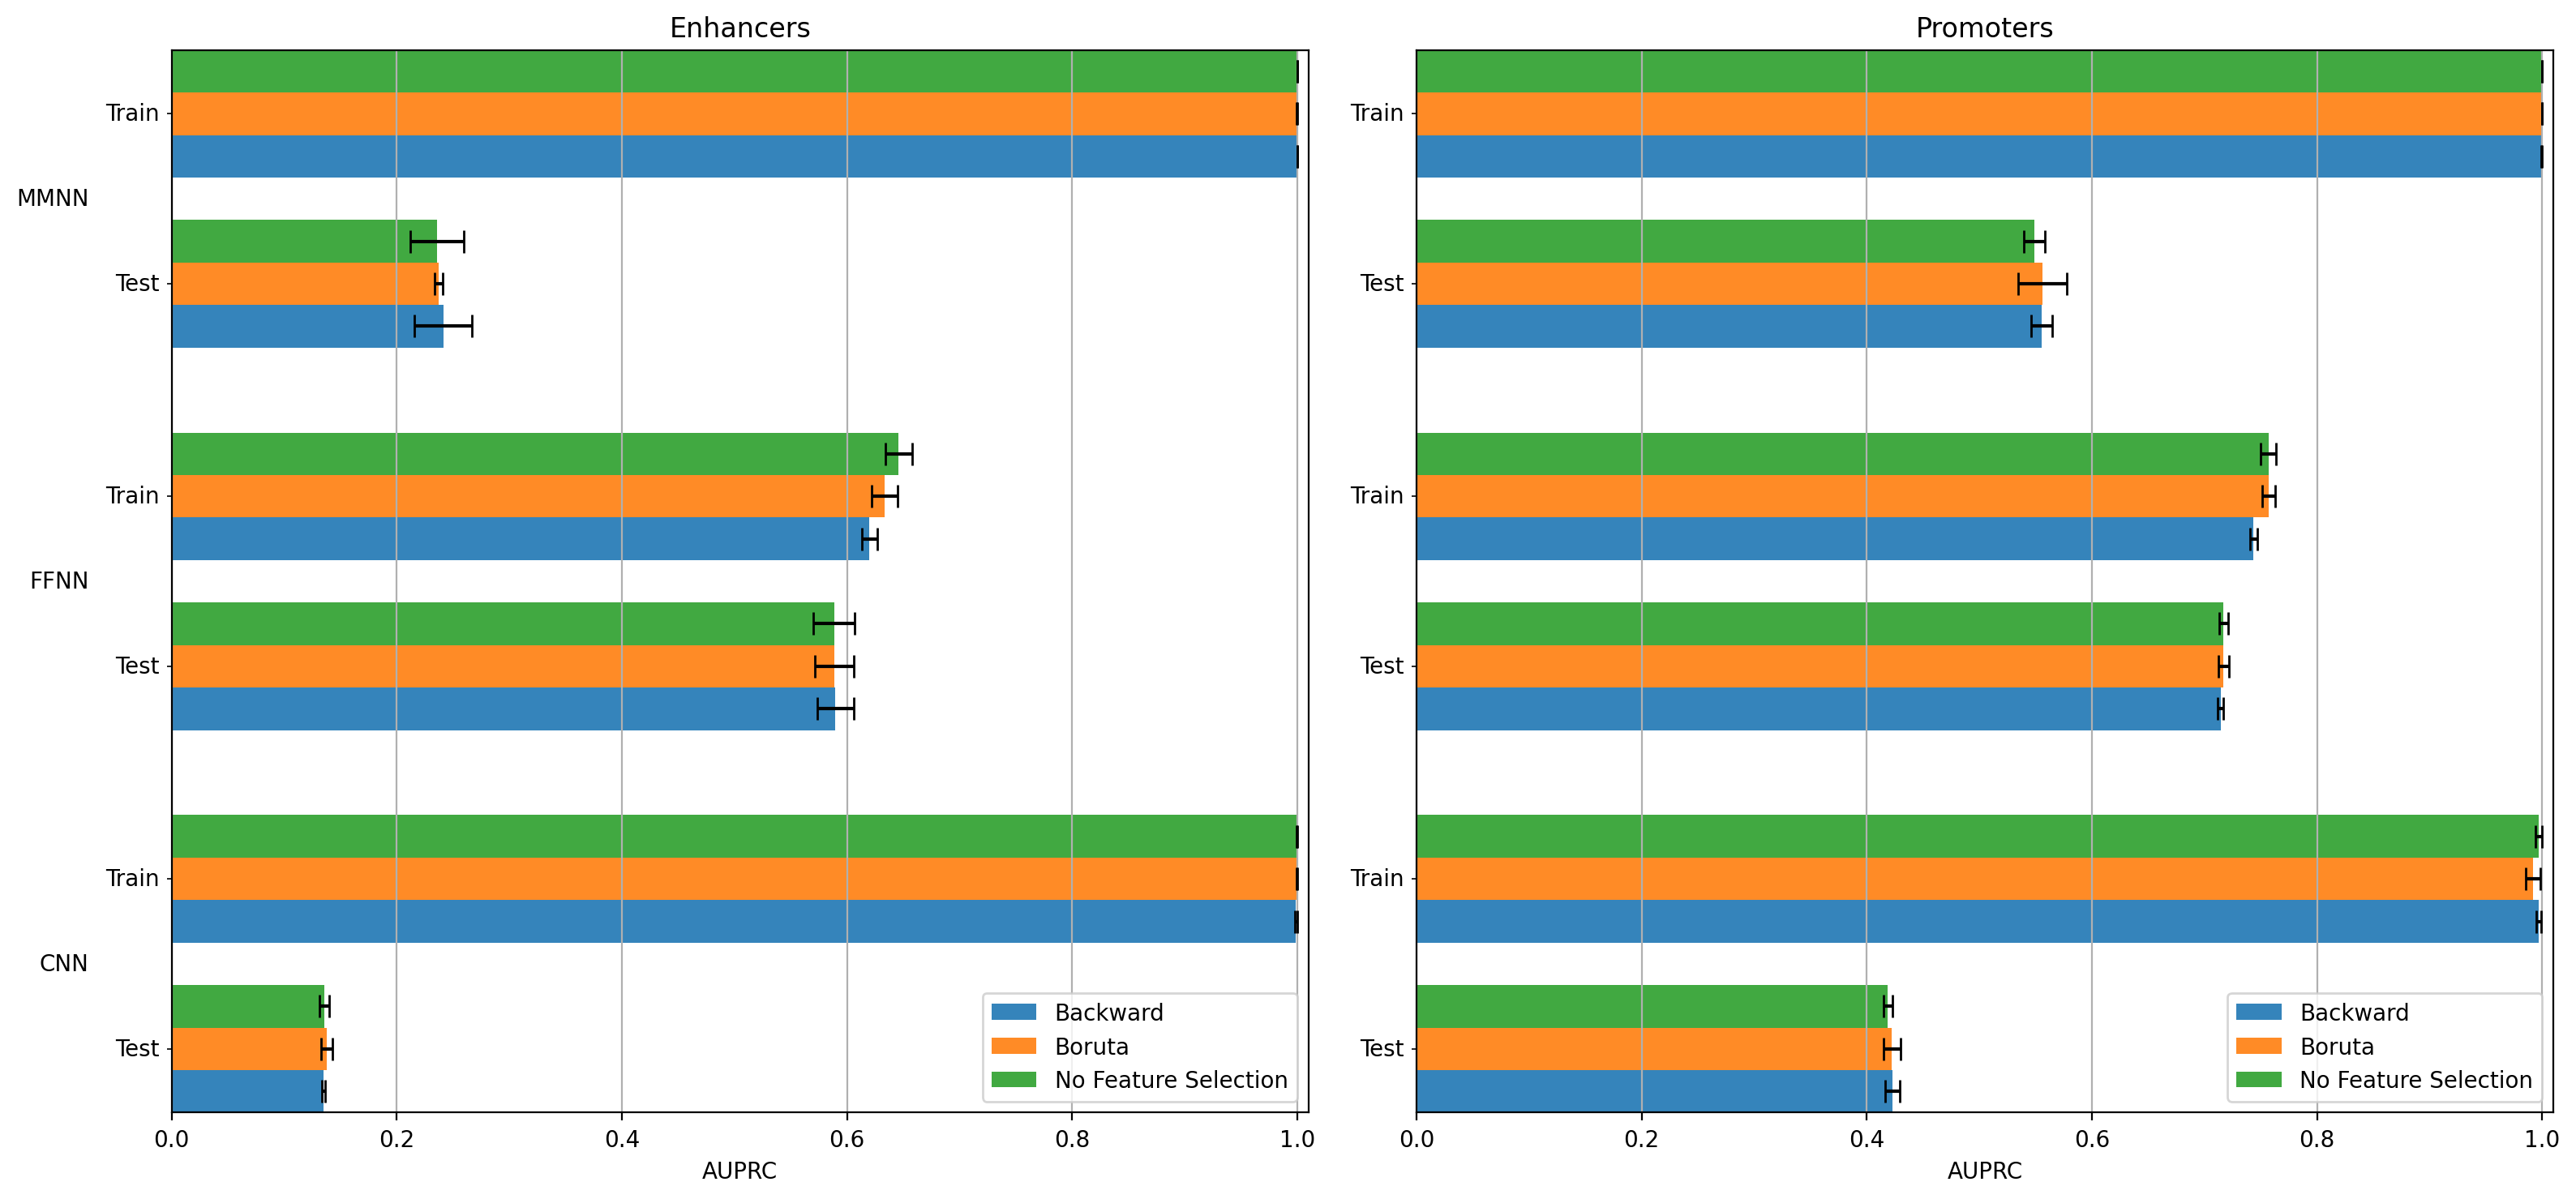

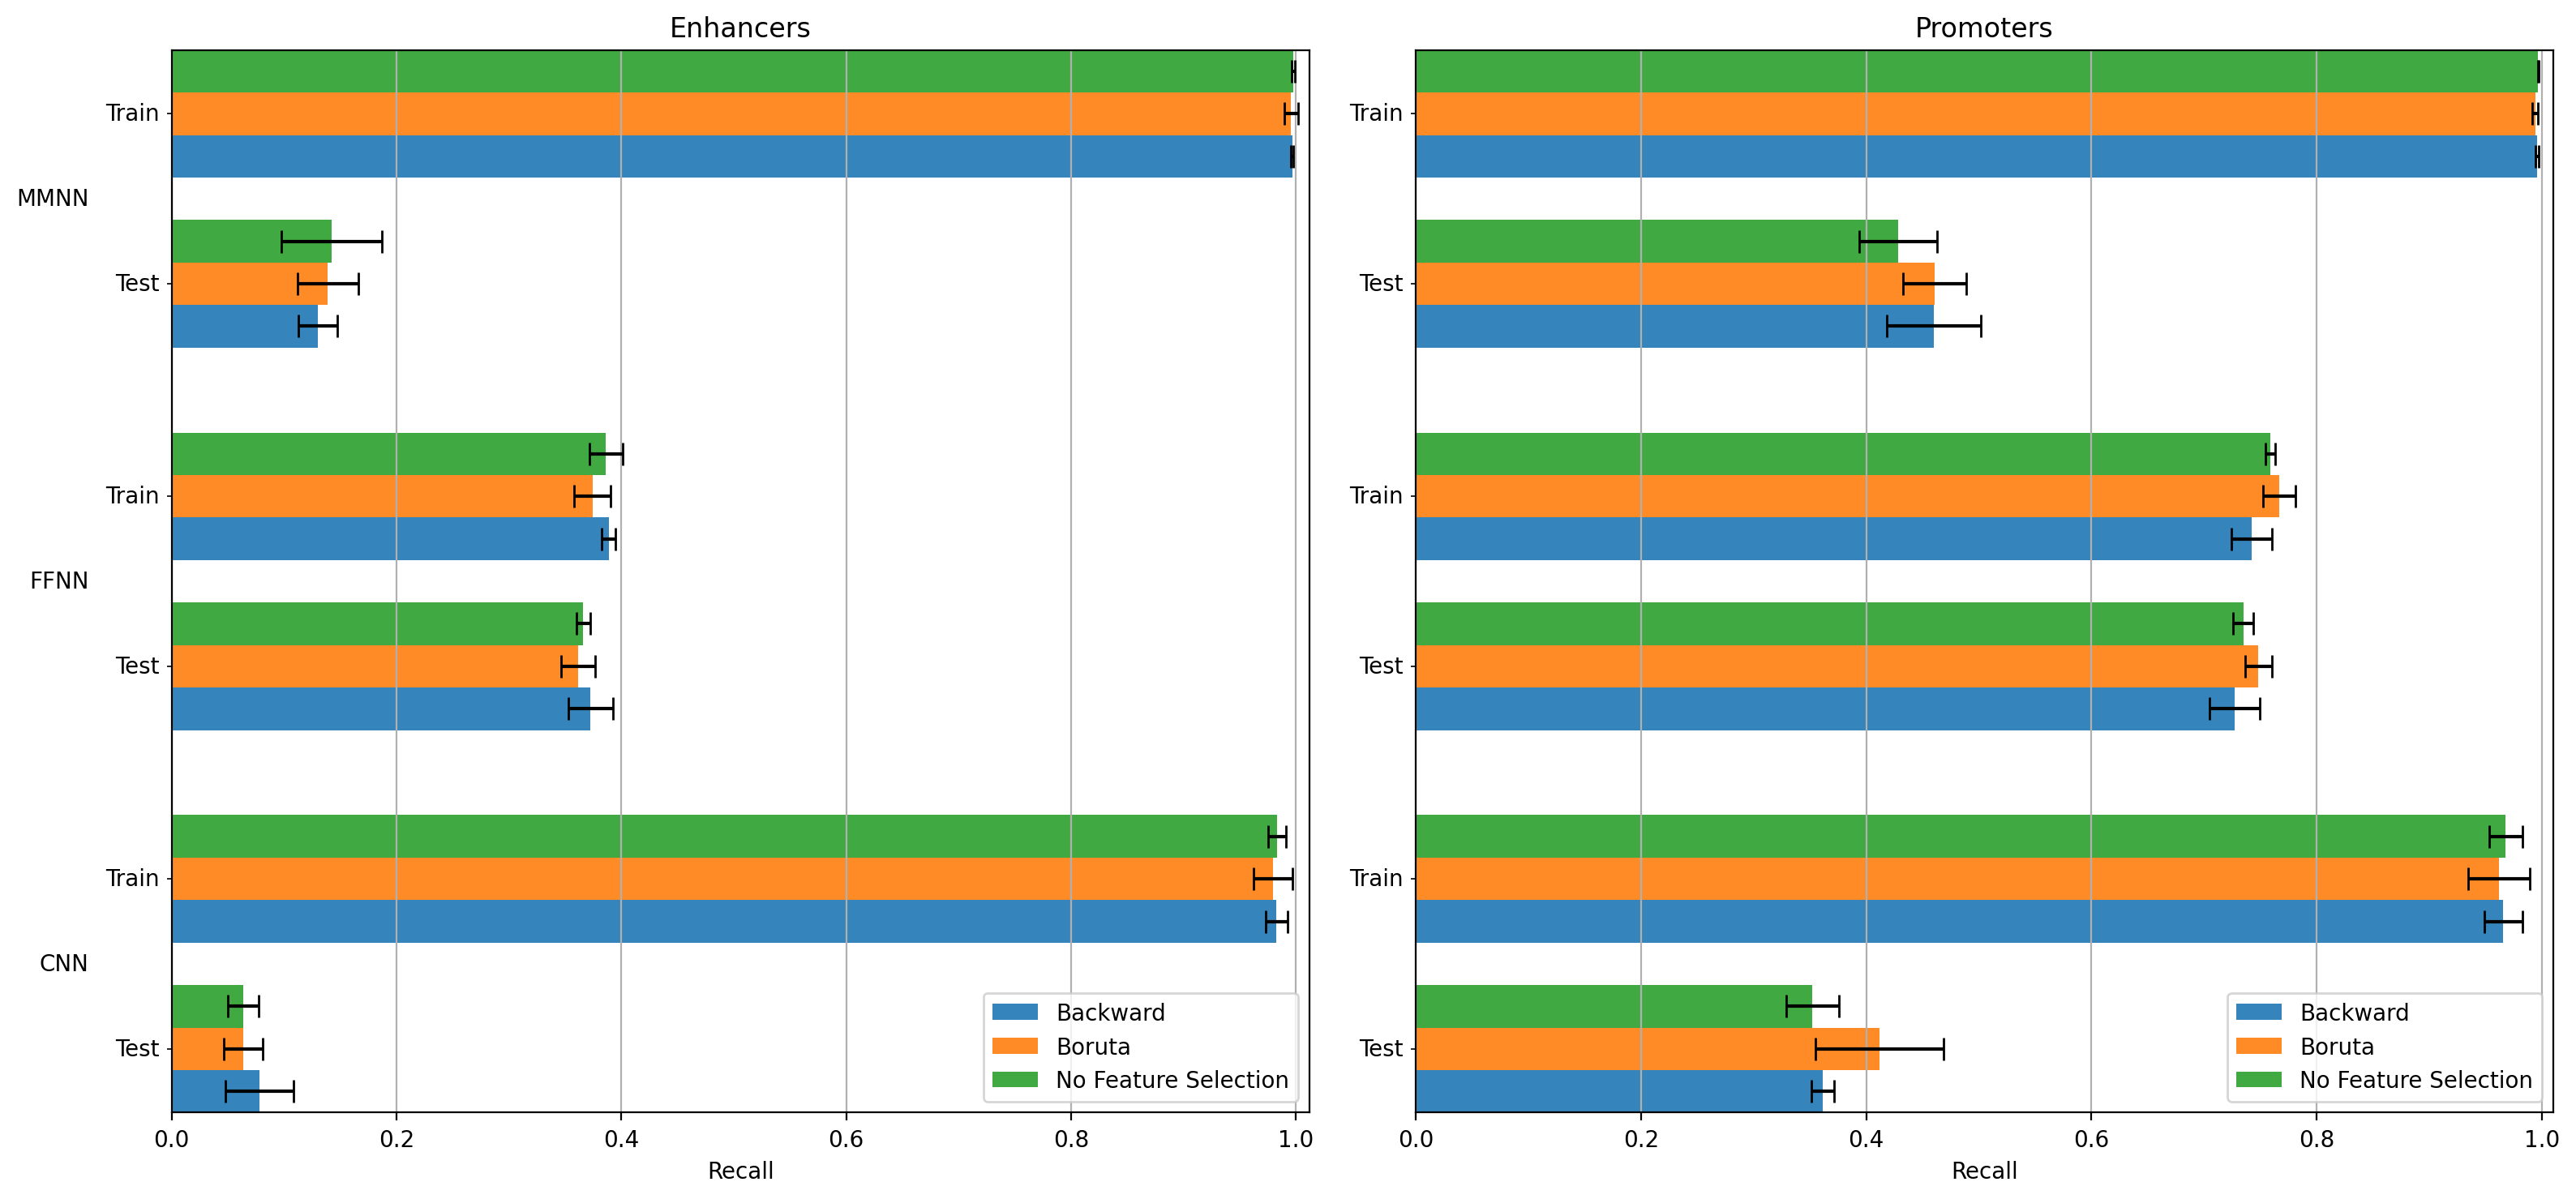

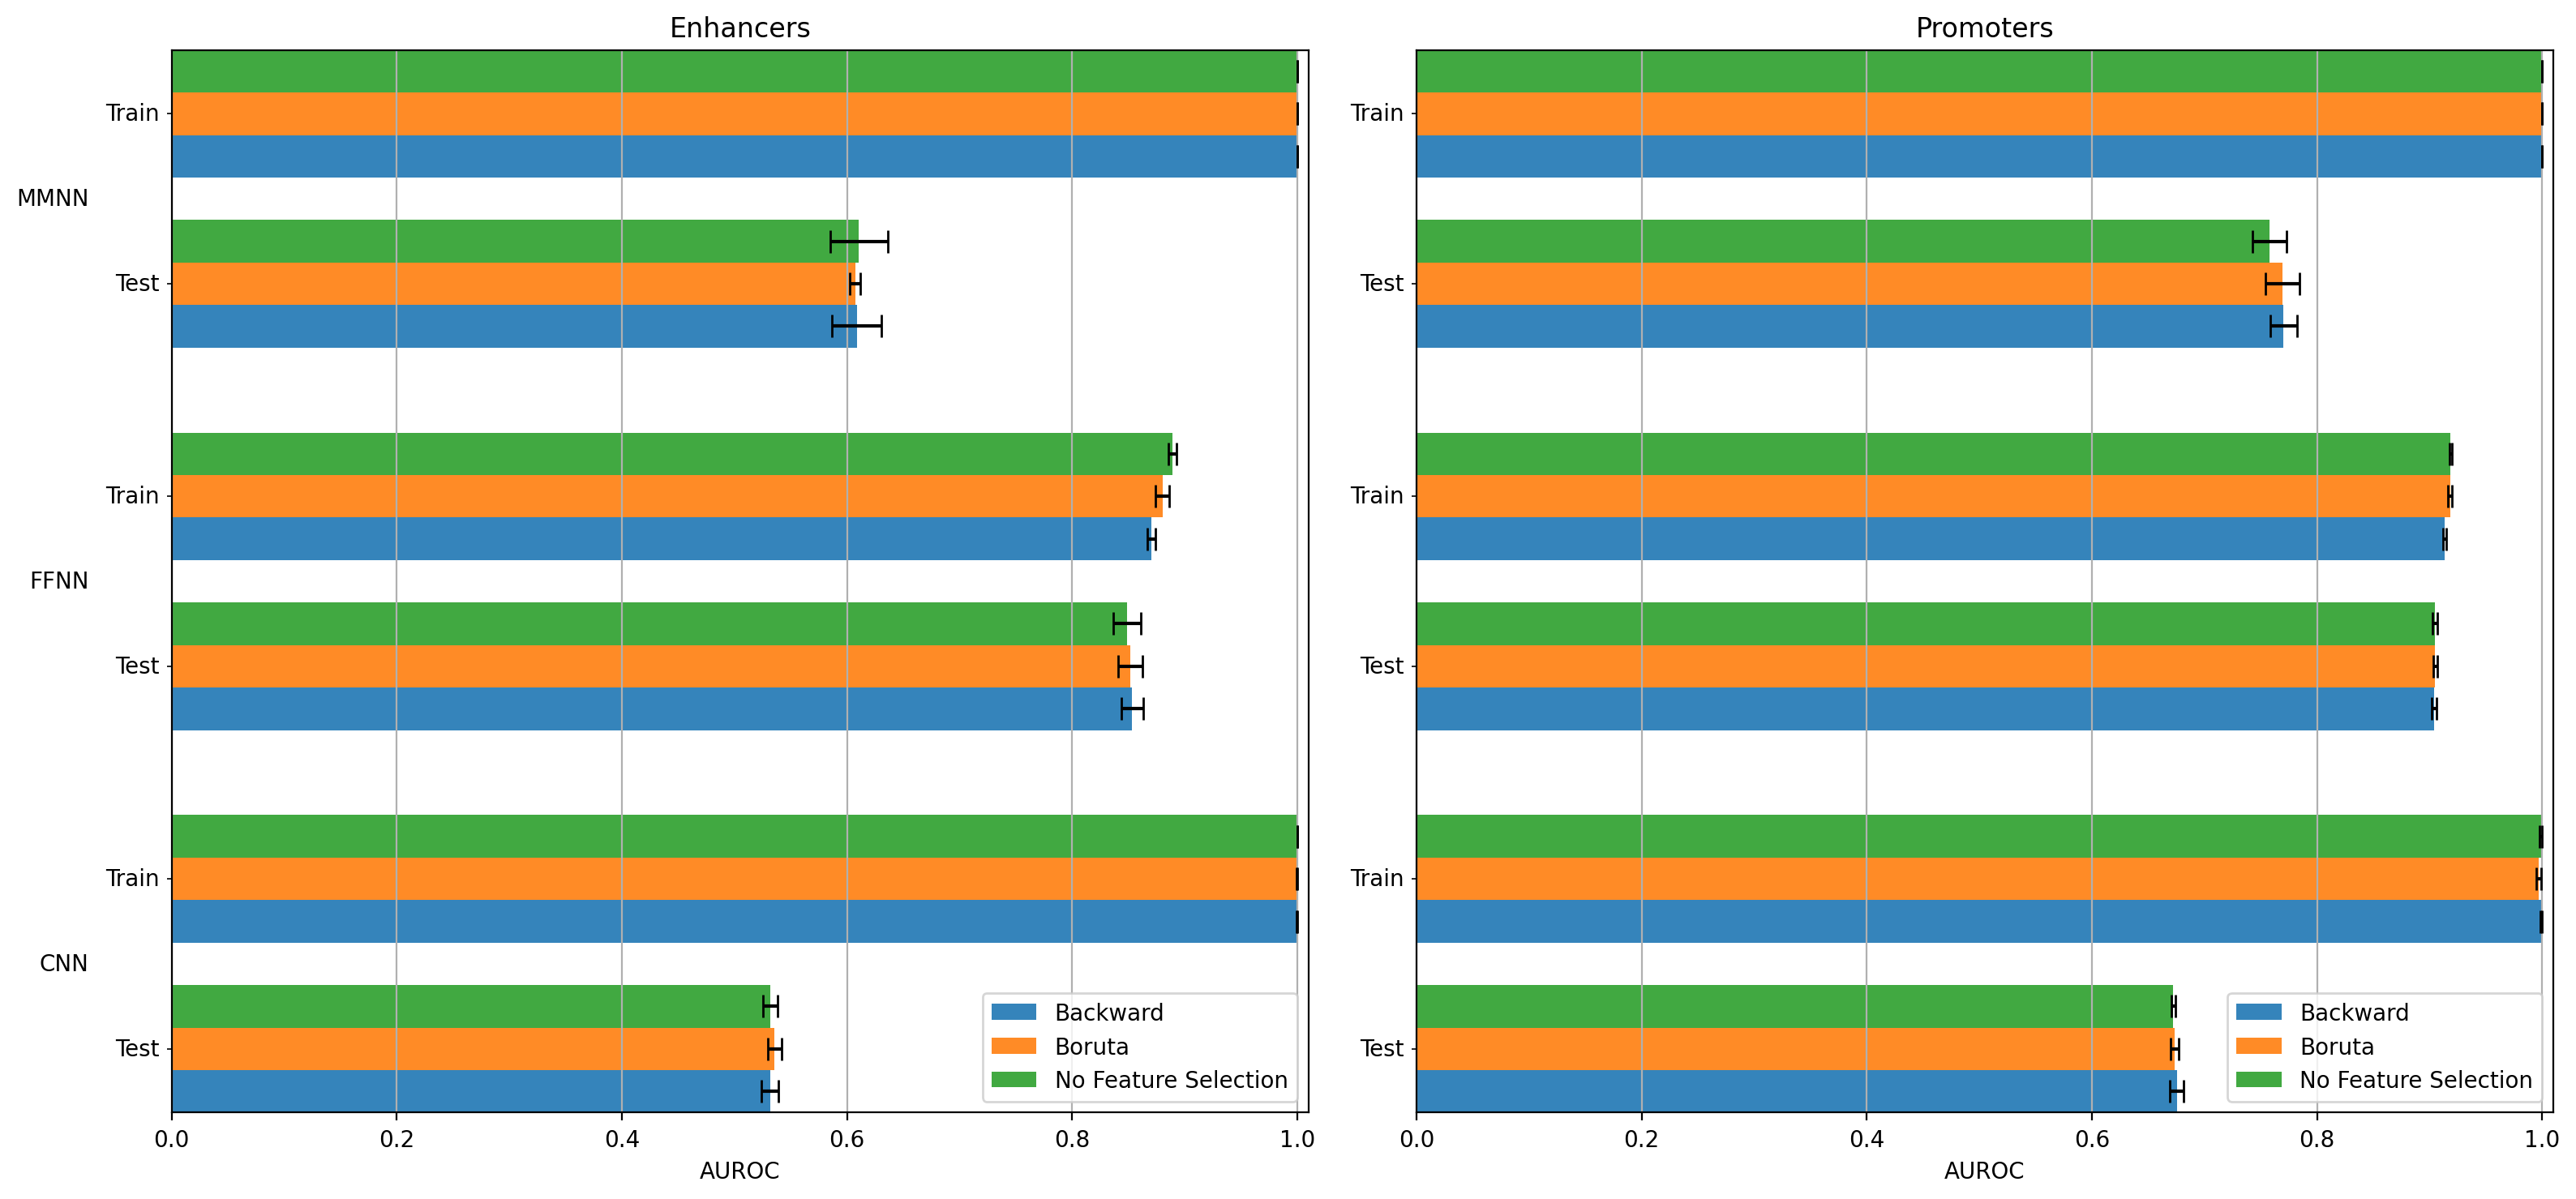

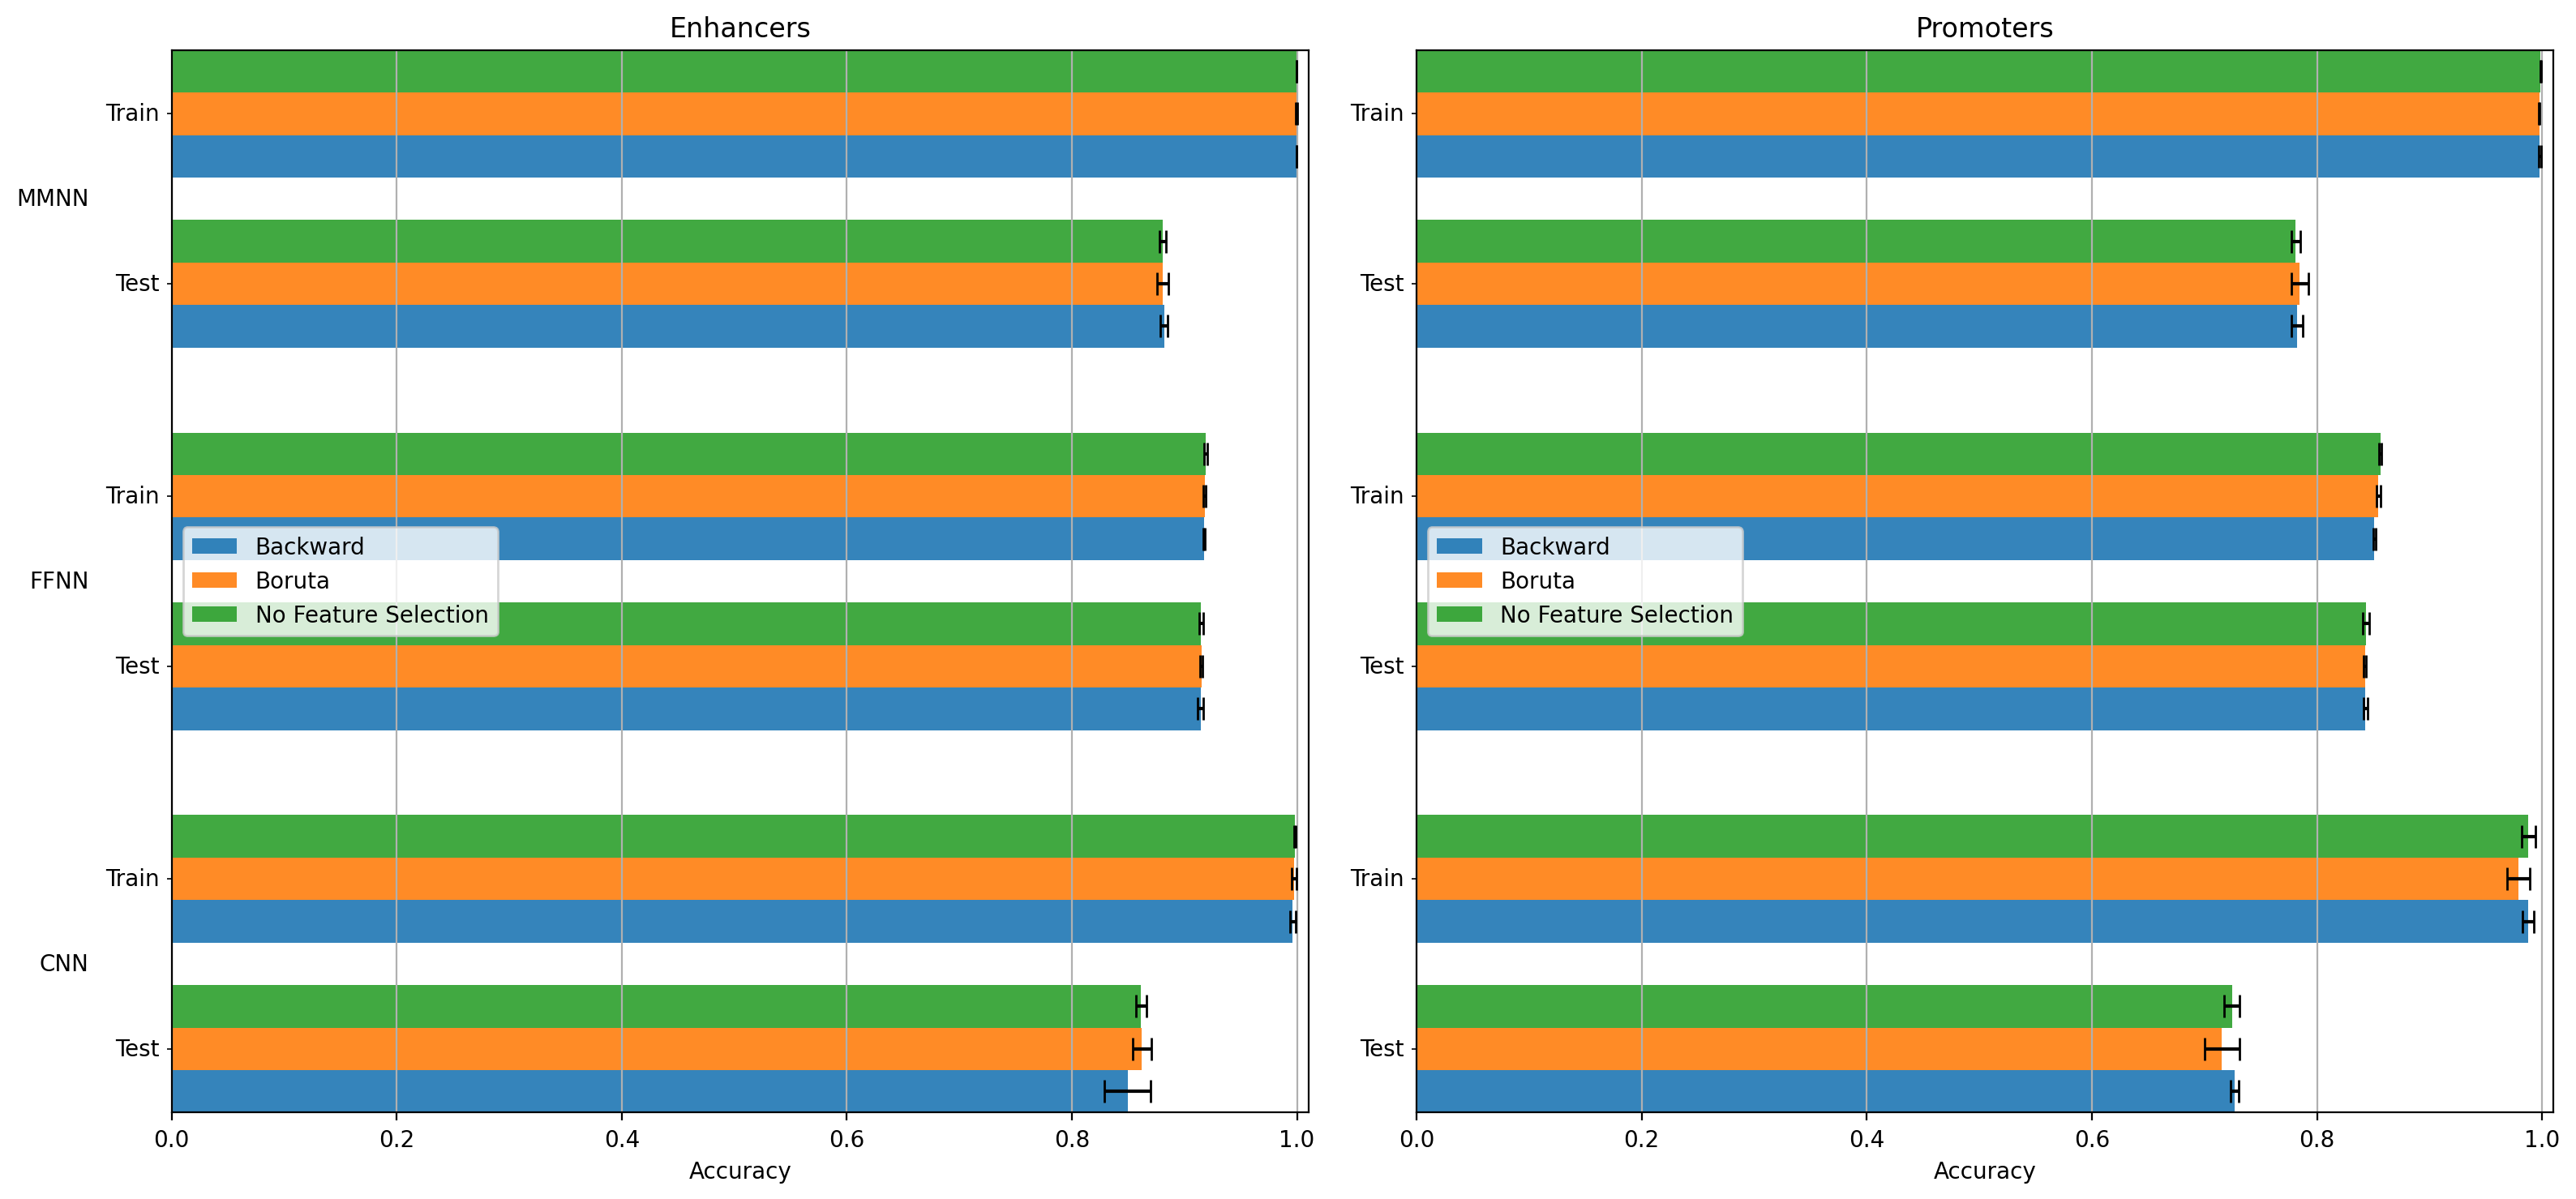

In [143]:
barplots(
    all_performance,
    groupby=["region", "model_name", "run_type", "feature_selection"],
    orientation="horizontal",
    height=8,
    show_legend=True,
    subplots=True
)
plt.show()

In [39]:
import pickle 
with open('./pickle/all-performances.pkl', 'wb') as file:
    pickle.dump(all_performance, file)

In [1]:
import pickle 
with open('./pickle/all-performances.pkl', 'rb') as file:
    all_performance = pickle.load(file)

In [2]:
all_performance

accuracy    recall  precision     AUROC     AUPRC run_type model_name  \
0   0.920439  0.404389   0.792491  0.893222  0.658111    train       FFNN   
1   0.913171  0.359582   0.741379  0.833118  0.568214     test       FFNN   
0   0.997175  0.975792   0.999287  0.999966  0.999759    train        CNN   
1   0.866319  0.056446   0.193317  0.525755  0.132803     test        CNN   
0   0.999506  0.995820   0.999825  1.000000  0.999998    train       MMNN   
..       ...       ...        ...       ...       ...      ...        ...   
1   0.840617  0.697111   0.689093  0.903381  0.716064     test       FFNN   
0   0.989900  0.978182   0.982612  0.999091  0.997349    train        CNN   
1   0.721680  0.367462   0.451944  0.675375  0.424524     test        CNN   
0   0.997197  0.994182   0.994954  0.999925  0.999751    train       MMNN   
1   0.789408  0.518325   0.608053  0.784639  0.568733     test       MMNN   

       region     feature_selection  
0   enhancers  No Feature Selection  
1   enhancers  No Feature Selection  
0   enhancers  No Feature Selection  
1   enhancers  No Feature Selection  
0   enhancers  No Feature Selection  
..        ...                   ...  
1   promoters              Backward  
0   promoters              Backward  
1   promoters              Backward  
0   promoters              Backward  
1   promoters              Backward  

[144 rows x 9 columns]

# Final result analysis

Baseline in order to assess the quality of the AUPRC results

In [141]:
for region, x in binary_labels.items():
    baseline = len(x[x.values == True])/len(x)
    print("AUPRC baseline for {} region is {}".format(region, baseline))

AUPRC baseline for promoters region is 0.25812717133388735
AUPRC baseline for enhancers region is 0.11340760053725212


# wilcoxon test

In [150]:
from scipy.stats import wilcoxon

# if pvalue is higher than threhsold (0.01, 0.05) we can claim that the results are 
# statistically indistiguishable

metrics_list = ("AUPRC", "AUROC", "precision", "recall","accuracy")
feature_selection_names = ("No Feature Selection", "Backward", "Boruta")



for outer_feature_selection in feature_selection_names:
    for model in all_performance.model_name.unique():
        outer_model_performance = all_performance[
            (all_performance.model_name == model) &
            (all_performance.run_type == "test") & 
            (all_performance.feature_selection == outer_feature_selection)
        ]
        for inner_feature_selection in feature_selection_names:
            if outer_feature_selection >= inner_feature_selection:
                continue
            model_performance = all_performance[
                (all_performance.model_name == model) &
                (all_performance.run_type == "test") & 
                (all_performance.feature_selection == inner_feature_selection)
            ]

            for metric in metrics_list:
                outer, inner = outer_model_performance[metric], model_performance[metric]
                _, p_value = wilcoxon(outer, inner)
                if p_value < 0.05:
                    if outer.mean() > inner.mean():
                        best_FS, worse_FS = outer_feature_selection, inner_feature_selection
                    else:
                        best_FS, worse_FS = inner_feature_selection, outer_feature_selection
                    print("The FS {} outperforms the {} with p-value {} on metric {} for model {}.".format(
                        best_FS,
                        worse_FS,
                        p_value,
                        metric,
                        model
                    ))
                else:
                    print("The FS {} is statistially indistinguishiable from {} with p-value {} on metric {} for model {}.".format(
                        outer_feature_selection, 
                        inner_feature_selection,
                        p_value,
                        metric,
                        model
                    ))


The FS Backward is statistially indistinguishiable from No Feature Selection with p-value 0.640625 on metric AUPRC for model FFNN.
The FS Backward is statistially indistinguishiable from No Feature Selection with p-value 0.1953125 on metric AUROC for model FFNN.
The FS Backward is statistially indistinguishiable from No Feature Selection with p-value 0.1484375 on metric precision for model FFNN.
The FS Backward is statistially indistinguishiable from No Feature Selection with p-value 0.84375 on metric recall for model FFNN.
The FS Backward is statistially indistinguishiable from No Feature Selection with p-value 0.7421875 on metric accuracy for model FFNN.
The FS Backward is statistially indistinguishiable from Boruta with p-value 0.546875 on metric AUPRC for model FFNN.
The FS Backward is statistially indistinguishiable from Boruta with p-value 0.7421875 on metric AUROC for model FFNN.
The FS Backward is statistially indistinguishiable from Boruta with p-value 0.3828125 on metric prec

In [102]:
from scipy.stats import wilcoxon

# if pvalue is higher than threhsold (0.01, 0.05) we can claim that the results are 
# statistically indistiguishable

metrics_list = ("AUPRC", "AUROC", "precision", "recall","accuracy")
feature_selection_names = ("No Feature Selection", "Backward", "Boruta")



for outer_model in all_performance.model_name.unique():
    for feature_selection in feature_selection_names:
        outer_model_performance = all_performance[
            (all_performance.model_name == outer_model) &
            (all_performance.run_type == "test") & 
            (all_performance.feature_selection == feature_selection)
        ]
        for model in all_performance.model_name.unique():
            if outer_model >= model:
                continue
            model_performance = all_performance[
                (all_performance.model_name == model) &
                (all_performance.run_type == "test") & 
                (all_performance.feature_selection == feature_selection)
            ]

            for metric in metrics_list:
                outer, inner = outer_model_performance[metric], model_performance[metric]
                _, p_value = wilcoxon(outer, inner)
                if p_value < 0.01:
                    if outer.mean() > inner.mean():
                        best_model, worse_model = outer_model, model
                    else:
                        best_model, worse_model = model, outer_model
                    print("The model {} outperforms the model {} with p-value {} on metric {} for feature selection method {}.".format(
                        best_model,
                        worse_model,
                        p_value,
                        metric,
                        feature_selection
                    ))
                else:
                    print("The model {} is statistially indistinguishiable {} with p-value {} on metric {} for feature selection method {}.".format(
                        outer_model,
                        model,
                        p_value,
                        metric,
                        feature_selection
                    ))


The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric AUPRC for feature selection method No Feature Selection.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric AUROC for feature selection method No Feature Selection.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric precision for feature selection method No Feature Selection.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric recall for feature selection method No Feature Selection.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric accuracy for feature selection method No Feature Selection.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric AUPRC for feature selection method Backward.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric AUROC for feature selection method Backward.
The model FFNN outperforms the model MMNN with p-value 0.0078125 on metric precision for fea